In [14]:
import wandb
import os
import sys
import datetime
def add_to_sys_path(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        sys.path.append(dirpath)
        
root_dir = '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/'
add_to_sys_path(root_dir)

from FFNNmodel import FeedforwardNeuralNetwork, ffnn_train, ffnn_evaluate, ffnn_predict
from neural_audio_dataset import NeuralAudioDataset
import utils.audio_utils as au
import utils.encodec_utils as eu
import utils.signal_utils as su
import utils.train_utils as tu

exec(open('/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/utils/all_imports.py').read())

In [15]:
# --------- EXPERIMENT CONFIG --------- #
run_idx = 0 

# Extract experiment params from JSON config file
config_path = '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/configs/config_raw_RA_z_r12r13_21.json'
with open(config_path, 'r') as file:
        configs = json.load(file)

# Directories of interest
data_dir = configs['common_dirs']['dataset_dir']
models_checkpoints_dir = configs['common_dirs']['models_checkpoints_dir']

# Experiment params
dataset_filename = configs['common_params']['dataset_filename']
neural_mode = configs['common_params']['neural_mode']
nucleus = configs['common_params']['nucleus']
neural_key = configs['common_params']['neural_key']
network = configs['common_params']['network']
bird = configs['common_params']['bird']
date = configs['common_params']['date']
session = configs['common_params']['session']

# Run params
config_id = configs['runs'][run_idx]['id']

# Data_processing_params
neural_history_ms = configs['runs'][run_idx]['data_processing_params']["neural_history_ms"]
gaussian_smoothing_sigma = configs['runs'][run_idx]['data_processing_params']["gaussian_smoothing_sigma"]

# Data_augmentation_params
max_temporal_shift_ms = configs['runs'][run_idx]['data_augmentation_params']["max_temporal_shift_ms"]
noise_level = configs['runs'][run_idx]['data_augmentation_params']["noise_level"]
transform_probability = configs['runs'][run_idx]['data_augmentation_params']["transform_probability"]

# Model_params
hidden_layer_sizes = configs['runs'][run_idx]['model_params']["hidden_layer_sizes"]
dropout_prob = configs['runs'][run_idx]['model_params']["dropout_prob"]

# Training_params
percent_train = configs['runs'][run_idx]['training_params']["percent_train"]
percent_test = configs['runs'][run_idx]['training_params']["percent_test"]
batch_size = configs['runs'][run_idx]['training_params']["batch_size"]
learning_rate = configs['runs'][run_idx]['training_params']["learning_rate"]
num_epochs = configs['runs'][run_idx]['training_params']["num_epochs"]

# Override params
# learning_rate = 4e-4
# num_epochs = 60

In [ ]:
# --------- LOAD DATA --------- #

# Open the file in binary read mode ('rb') and load the content using pickle
with open(data_dir + dataset_filename + '.pkl', 'rb') as file:
    data_dict = pkl.load(file)

# Extarct data from dataset
neural_array = data_dict['neural_dict'][neural_key]
audio_motifs = data_dict['audio_motifs']
fs_audio = data_dict['fs_audio']
fs_neural = data_dict['fs_neural']

# Calculate the duration based on the last dimension of the arrays and their sampling rates
trial_length_neural = (neural_array.shape[-1] / fs_neural)*1000
trial_length_audio = (audio_motifs.shape[-1] / fs_audio)*1000

# Check the durations of the neural/audio data are equal and raise a warning if they aren't
print('Length of neural trials: {} ms, length of audio trials: {} ms. '.format(trial_length_neural, trial_length_audio))
if trial_length_neural != trial_length_audio:
    warnings.warn("WARNING: Neural data duration and audio motifs duration are different in this dataset!")


# --------- PROCESS AUDIO --------- #

b, a = fh.load_filter_coefficients_matlab('/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/filters/butter_bp_250Hz-8000hz_order4_sr25000.mat')
audio_motifs = fh.noncausal_filter_2d(audio_motifs, b=b, a=a)

# Reduce noise
for m in range(len(audio_motifs)):
    audio_motifs[m] = nr.reduce_noise(audio_motifs[m], sr=fs_audio)


# --------- INSTANTIATE ENCODEC --------- #

# Instantiate a pretrained EnCodec model
encodec_model = EncodecModel.encodec_model_48khz()
# bandwidth = 24kbps for 48kHz model (n_q=16)
encodec_model.set_target_bandwidth(24.0)

# Embed motifs
audio_embeddings, audio_codes, scales = eu.encodec_encode_audio_array_2d(audio_motifs, fs_audio, encodec_model)


# --------- PROCESS NEURAL --------- #

# Gaussian kernel along the temporal dimension of the spiketrains
neural_array = gaussian_filter1d(neural_array, sigma=gaussian_smoothing_sigma, axis=2) 

# Resample neural datato match audio embeddings
samples_neural = neural_array.shape[2]
samples_embeddings = audio_embeddings.shape[2]

# Calculate spikerate at given bin_size:
history_size = samples_neural//samples_embeddings
neural_array = sh.downsample_list_3d(neural_array, history_size, mode='sum')

bin_length = trial_length_neural / neural_array.shape[2] # ms
history_size = int(neural_history_ms // bin_length) # Must be minimum 1
print('Using {} bins of neural data history.'.format(history_size))


# --------- PREPARE DATALOADERS --------- #

num_motifs = len(neural_array)
num_train_examples = int(num_motifs * percent_train)
print('Out of the {} total motifs, the first {} are used for training. The rest, for testing.'.format(num_motifs, num_train_examples))

# Split the data into train and test sets
train_idxs = list(range(0, num_train_examples))
test_idxs = list(range(num_train_examples, num_motifs))
train_neural = neural_array[train_idxs]  
train_audio = audio_embeddings[train_idxs]
test_neural = neural_array[test_idxs]  
test_audio = audio_embeddings[test_idxs]

# Create dataset objects
max_temporal_shift_bins = int(max_temporal_shift_ms // bin_length) # Temporal jitter for data augmentation

train_dataset = NeuralAudioDataset(train_neural, 
                                   train_audio, 
                                   history_size, 
                                   max_temporal_shift=max_temporal_shift_bins,
                                   noise_level=noise_level,
                                   transform_probability=transform_probability)

test_dataset = NeuralAudioDataset(test_neural, 
                                  test_audio, 
                                  history_size, 
                                  max_temporal_shift=0,
                                  noise_level=0,
                                  transform_probability=0)

print('Train samples: ', len(train_dataset))
print('Test samples: ', len(test_dataset))

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# --------- TRAIN MODEL --------- #

# Initialize the neural network and optimizer
input, target = next(iter(train_dataset))
input_dim = input.shape[0]
output_dim = target.shape[0]
print('Input_dim: ', input_dim, ' -  Output dim: ', output_dim)

# Instantiate model
layers = [input_dim] + hidden_layer_sizes + [output_dim]
ffnn_model = FeedforwardNeuralNetwork(layers, dropout_prob=dropout_prob)
total_params = tu.compute_num_model_params(ffnn_model)

# Loss function and optimizer
criterion = nn.MSELoss() 
optimizer = optim.AdamW(ffnn_model.parameters(), lr=learning_rate)

# TRACK with WANDB
model_name = "_".join([bird, neural_mode, neural_key, network, datetime.datetime.now().strftime('%Y%m%d_%H%M%S')])
experiment_metadata = {
        "model_name": model_name,
        # Experiment
        "bird": bird,
        "session": session,
        "session_date": date,
        "dataset": dataset_filename,
        "config_path":config_path,
        "config_id": config_id,
        # Data
        "neural_mode": neural_mode,
        "nucleus": nucleus,
        "neural_key": neural_key,
        # Model
        "architecture": network,
        "layers": layers,
        "total_params": total_params,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        # Train-test split
        "train_idxs": train_idxs,
        "test_idxs": test_idxs,
        # Data processing
        "neural_history_ms": neural_history_ms,
        "gaussian_smoothing_sigma": gaussian_smoothing_sigma,
        # Data augmentation
        "max_temporal_shift_ms": max_temporal_shift_ms,
        "noise_level": noise_level,
        "transform_probability": transform_probability
    }

wandb.init(
    # set the wandb project where this run will be logged
    project = "_".join([bird, neural_mode, neural_key]),
    name = model_name, 

    # track hyperparameters and run metadata
    config = experiment_metadata
)

# Train
tot_train_loss, tot_train_err, tot_val_loss, tot_val_err = ffnn_train(ffnn_model, train_loader, optimizer, criterion, num_epochs, val_dataloader=test_loader)
print('Done training!')
wandb.finish()

Length of neural trials: 899.9666666666667 ms, length of audio trials: 899.96 ms. 


/tmp/ipykernel_907404/1095410660.py:20: UserWarning: WARNING: Neural data duration and audio motifs duration are different in this dataset!
  warnings.warn("WARNING: Neural data duration and audio motifs duration are different in this dataset!")


Using 3 bins of neural data history.
Out of the 47 total motifs, the first 37 are used for training. The rest, for testing.
Train samples:  4810
Test samples:  1320
Input_dim:  252  -  Output dim:  128
Layer: layers.0.weight | Size: torch.Size([64, 252]) | Number of Parameters: 16128
Layer: layers.0.bias | Size: torch.Size([64]) | Number of Parameters: 64
Layer: layers.1.weight | Size: torch.Size([128, 64]) | Number of Parameters: 8192
Layer: layers.1.bias | Size: torch.Size([128]) | Number of Parameters: 128
Total number of parameters in the model: 24512


Epoch [50/2000] Training Loss: 1.084398524255942, Training Error: 0.7466950637615279
Epoch [50/2000], Validation Loss: 1.1071632007757823, Validation Error: 0.7523088653882345
Epoch [100/2000] Training Loss: 1.0319411624346349, Training Error: 0.7304153596328584
Epoch [100/2000], Validation Loss: 1.0926471735749925, Validation Error: 0.7450925296261197
Epoch [150/2000] Training Loss: 1.0077423824379776, Training Error: 0.7237974342131457
Epoch [150/2000], Validation Loss: 1.1034465687615531, Validation Error: 0.7463914595899128
Epoch [200/2000] Training Loss: 0.99282328419338, Training Error: 0.7185165451851901
Epoch [200/2000], Validation Loss: 1.1028376860277993, Validation Error: 0.7434155259813581
Epoch [250/2000] Training Loss: 0.9851562128161753, Training Error: 0.716842781628994
Epoch [250/2000], Validation Loss: 1.104513766510146, Validation Error: 0.7446107878571465
Epoch [300/2000] Training Loss: 0.9609520573489714, Training Error: 0.7102230100442242
Epoch [300/2000], Validat

In [20]:
# --------- SAVE MODEL --------- #
if not os.path.exists(models_checkpoints_dir):
    os.makedirs(models_checkpoints_dir)

experiment_metadata['tot_train_loss'] = tot_train_loss
experiment_metadata['tot_train_err'] = tot_train_err
experiment_metadata['tot_val_loss'] = tot_val_loss
experiment_metadata['tot_val_err'] = tot_val_err

tu.save_model(models_checkpoints_dir, model_name, ffnn_model, optimizer, experiment_metadata)

Model statedict saved to /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/z_r12r13_21_RAW_ra_all_FFNN_20240407_212020.pt 
Experiment metadata saved to /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/z_r12r13_21_RAW_ra_all_FFNN_20240407_212020_metadata.json
Training session info saved:  /home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models_checkpoints/models_info.csv


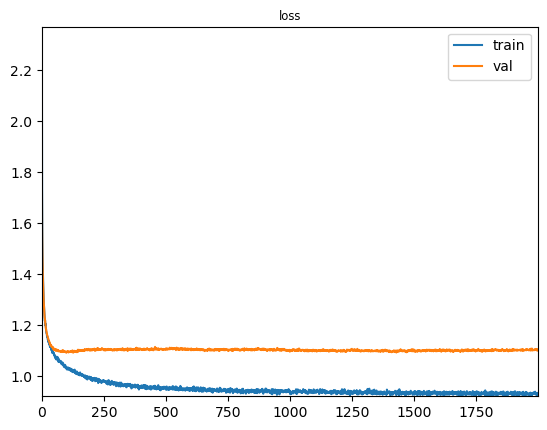

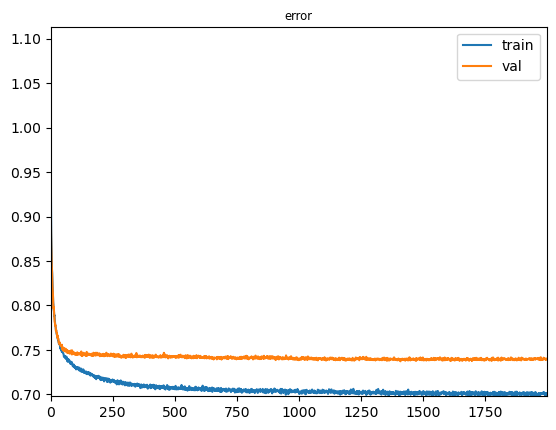

In [19]:
till_epoch = -1
# till_epoch = 500

fig, ax = plt.subplots()
ax.plot(tot_train_loss[:till_epoch], label='train')
ax.plot(tot_val_loss[:till_epoch], label='val')
ax.set_title('loss')
ax.legend()


fig, ax = plt.subplots()
ax.plot(tot_train_err[:till_epoch], label='train')
ax.plot(tot_val_err[:till_epoch], label='val')
ax.set_title('error')
ax.legend()

/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/util/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_907404/264536564.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


NameError: name 'loader' is not defined

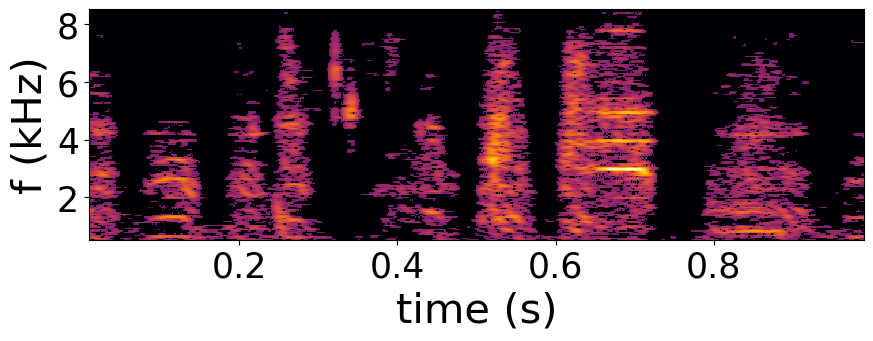

In [12]:
# Retrieve embeddings from dataset:
dataset = test_dataset
it = iter(dataset)
samples = []
for _ in range(len(dataset)):
    sample = next(it)
    samples.append(sample[1])  # assuming sample[1] is the tensor of interest
original_embeddings = torch.stack(samples, dim=0).permute(1,0)

original_audio = eu.audio_from_embedding(original_embeddings, scales[0], encodec_model, fs_audio).squeeze(0).squeeze(0)

samples = fs_audio*1
# samples = -1
# SPECTROGRAM
audio_trial = original_audio.detach().numpy()
fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
auts.plot_spectrogram(audio_trial[:samples], fs_audio, ax, f_min=500, f_max=8500)
# ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax.set_xlabel('time (s)', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.set_ylabel('f (kHz)', fontsize=30)
ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


# loader = test_loader
decoded_embeddings, error = ffnn_predict(ffnn_model, loader)
decoded_embeddings = decoded_embeddings.permute(1, 0)

decoded_embeddings = decoded_embeddings.to(scales.device)
decoded_audio = eu.audio_from_embedding(decoded_embeddings, scales[0], encodec_model, fs_audio).squeeze(0).squeeze(0)

samples = fs_audio*1
# samples = -1
# SPECTROGRAM
audio_trial = decoded_audio.detach().numpy()
fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
auts.plot_spectrogram(audio_trial[:samples], fs_audio, ax, f_min=500, f_max=8500)
# ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax.set_xlabel('time (s)', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.set_ylabel('f (kHz)', fontsize=30)
ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)

/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/util/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_907404/3723432017.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


[Text(0, 0.0, '0'),
 Text(0, 2000.0, '2'),
 Text(0, 4000.0, '4'),
 Text(0, 6000.0, '6'),
 Text(0, 8000.0, '8'),
 Text(0, 10000.0, '')]

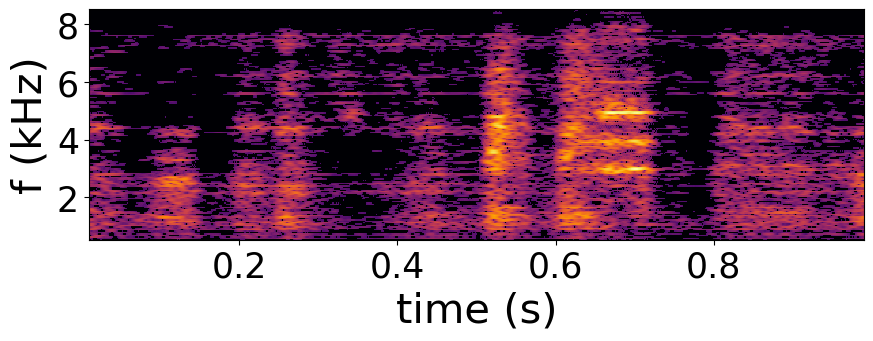

In [13]:
# Decoded embedding
loader = test_loader
# loader = test_loader
decoded_embeddings, error = ffnn_predict(ffnn_model, loader)
decoded_embeddings = decoded_embeddings.permute(1, 0)

decoded_embeddings = decoded_embeddings.to(scales.device)
decoded_audio = eu.audio_from_embedding(decoded_embeddings, scales[0], encodec_model, fs_audio).squeeze(0).squeeze(0)

samples = fs_audio*1
# samples = -1
# SPECTROGRAM
audio_trial = decoded_audio.detach().numpy()
fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
auts.plot_spectrogram(audio_trial[:samples], fs_audio, ax, f_min=500, f_max=8500)
# ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax.set_xlabel('time (s)', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.set_ylabel('f (kHz)', fontsize=30)
ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)

In [14]:
0.2*47

9.4

### This notebook is to develop and test the decoding pipeline

In [5]:
# --------- IMPORTS --------- #

import sys
import argparse

from FFNNmodel import FeedforwardNeuralNetwork, ffnn_predict, ffnn_train, ffnn_evaluate
import utils.audio_utils as au
import utils.encodec_utils as eu
import utils.signal_utils as su

sys.path.append('/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/')
sys.path.append('/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/utils/')
exec(open('/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/utils/all_imports.py').read())

In [6]:
data_dir = '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/data_for_models/'
file_path = data_dir + 'RAW_z_w12m7_20_20240325_210721.pkl'

# Open the file in binary read mode ('rb') and load the content using pickle
with open(file_path, 'rb') as file:
    data_dict = pkl.load(file)

# Extarct data from dataset
neural_key = 'ra_all'
neural_array = data_dict['neural_dict'][neural_key]
audio_motifs = data_dict['audio_motifs']

fs_audio = data_dict['fs_audio']
fs_neural = data_dict['fs_neural']

In [7]:
# Calculate the duration based on the last dimension of the arrays and their sampling rates
trial_length_neural = (neural_array.shape[-1] / fs_neural)*1000
trial_length_audio = (audio_motifs.shape[-1] / fs_audio)*1000

# Print the durations for verification
print('Length of neural trials: {} ms, length of audio trials: {} ms. '.format(trial_length_neural, trial_length_audio))

# Check if the durations are different and raise a warning if they are
if trial_length_neural != trial_length_audio:
    warnings.warn("WARNING: Neural data duration and audio motifs duration are different in this dataset!")

Length of neural trials: 700.0 ms, length of audio trials: 700.0 ms. 


In [8]:
print(data_dict.keys())
print(data_dict['neural_dict'].keys())

print(neural_array.shape, audio_motifs.shape)
print(neural_array.shape[-1]/fs_neural, audio_motifs.shape[-1]/fs_audio)


dict_keys(['neural_dict', 'audio_motifs', 'audio_labels', 'fs_neural', 'fs_audio', 't_pre', 't_post', 'sess_params'])
dict_keys(['ra_sua', 'ra_all', 'hvc_sua', 'hvc_all'])
(10, 172, 21000) (10, 17500)
0.7 0.7


In [9]:
# --------- PROCESS AUDIO --------- #

b, a = fh.load_filter_coefficients_matlab('/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/filters/butter_bp_250Hz-8000hz_order4_sr25000.mat')
audio_motifs = fh.noncausal_filter_2d(audio_motifs, b=b, a=a)

# Reduce noise
for m in range(len(audio_motifs)):
    audio_motifs[m] = nr.reduce_noise(audio_motifs[m], sr=fs_audio)

In [11]:
# --------- ENCODEC --------- #

# Instantiate a pretrained EnCodec model
encodec_model = EncodecModel.encodec_model_48khz()
# bandwidth = 24kbps for 48kHz model (n_q=16)
encodec_model.set_target_bandwidth(24.0)

# Embed motifs
audio_embeddings, audio_codes, scales = eu.encodec_encode_audio_array_2d(audio_motifs, fs_audio, encodec_model)

print(audio_embeddings.shape, audio_codes.shape, scales.shape)


torch.Size([10, 128, 105]) torch.Size([10, 16, 105]) torch.Size([10])


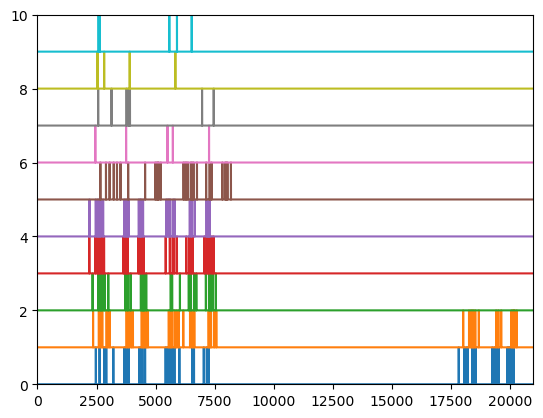

In [12]:
for i in range(len(neural_array)):
    plt.plot(neural_array[i][120] + i)

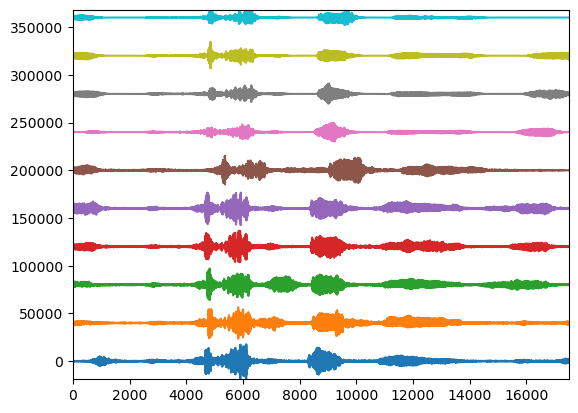

In [13]:
for i in range(len(audio_motifs)):
    plt.plot(audio_motifs[i] + 40000*i)

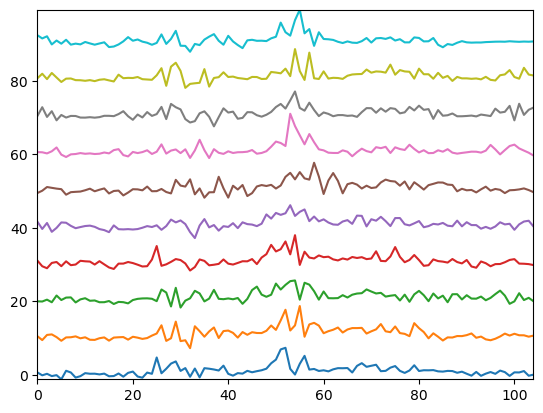

In [14]:
for i in range(len(audio_embeddings)):
    plt.plot(audio_embeddings[i][55] + 10*i)

In [15]:
# --------- PREPARE LOADERS --------- #

# Gaussian kernel to smooth spiketrains
sigma = 30  
neural_array = gaussian_filter1d(neural_array, sigma=sigma, axis=2) # Gaussian filter along the temporal dimension

# Resample neural datato match audio embeddings
samples_neural = neural_array.shape[2]
samples_embeddings = audio_embeddings.shape[2]

# Calculate spikerate at given bin_size:
history_size = samples_neural//samples_embeddings
neural_array = sh.downsample_list_3d(neural_array, history_size, mode='sum')


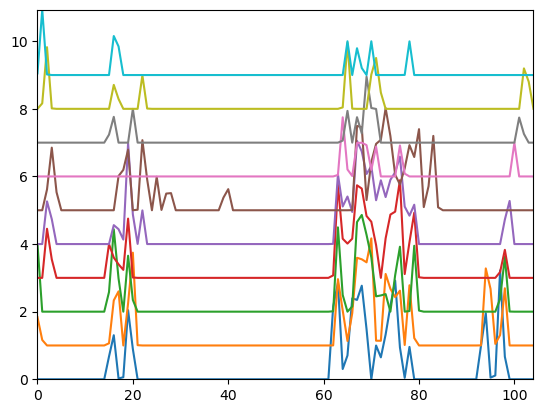

In [16]:
for i in range(len(neural_array)):
    plt.plot(neural_array[i][50] + i)

In [17]:
bin_length = trial_length_neural / neural_array.shape[2] # ms

neural_hist =  20 # neural history in ms
history_size = int(neural_hist // bin_length) # Must be minimum 1

print('Using {} bins of neural data history.'.format(history_size))

Using 2 bins of neural data.


In [18]:
neural_array.shape, audio_embeddings.shape

((10, 172, 105), torch.Size([10, 128, 105]))

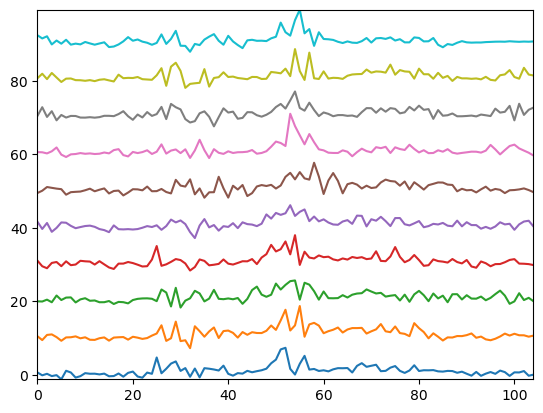

In [19]:
for i in range(len(audio_embeddings)):
    plt.plot(audio_embeddings[i][55] + 10*i)

In [20]:
class NeuralAudioDataset(Dataset):
    def __init__(self, 
                 neural_data, 
                 audio_data, 
                 history_samples, 
                 max_temporal_shift=0, 
                 noise_level=0, 
                 transform_probability=0.5):
        '''
        neural_data = [trials x neural_channels x samples]
        audio_data = [trials x audio_features x samples]
        history_samples = Number of neural samples used to predict each audio sample
        max_temporal_shift = Maximum allowed temporal shift (in samples) for data augmentation
        noise_level = Standard deviation of Gaussian noise added to neural data for augmentation
        transform_probability = Probability of applying temporal shift augmentation and/or noise augmentation
        '''
        
        self.neural_data = neural_data
        self.audio_data = audio_data
        self.history_size = history_samples
        self.max_temporal_shift = max_temporal_shift
        self.noise_level = noise_level
        self.p = transform_probability

        assert self.neural_data.shape[0] == self.audio_data.shape[0], "Number of trials must match in both datasets"
        assert self.neural_data.shape[-1] == self.audio_data.shape[-1], "Number of samples must match in both datasets"
        
        self.inputs, self.targets = [], []
        for trial in range(self.neural_data.shape[0]):
            # Skip history_size bins. 
            for sample in range(self.history_size+self.max_temporal_shift, self.neural_data.shape[2]-self.max_temporal_shift): 
                # Store indices of neural data corresponding to each audio sample to later retrieve neural data w/out temporal jitter.
                self.inputs.append((trial, sample))  
                self.targets.append(self.audio_data[trial, :, sample])

        # Total number of samples
        assert len(self.inputs) == len(self.targets), "Number of inputs and targets must match"
        self.total_samples = len(self.inputs)

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        trial, sample = self.inputs[idx]
        neural_sample = self.neural_data[trial, :, sample - self.history_size:sample]
        audio_sample = self.targets[idx]  # Corresponding audio sample

        # DATA AUGMENTATION
        
        # Apply temporal shift augmentation with probability p
        if np.random.rand() < self.p:
            # ! WARNING: keep in mind that this will result in neural traces with all zeros if at the start/end of the trial.
            # To prevent this behavior, add self.max_temporal_shift to the constructor of the self.inputs, although it will result in less data for training.
            shift = np.random.randint(-self.max_temporal_shift, self.max_temporal_shift + 1)
            start_idx = max(0, sample - self.history_size + shift)
            end_idx = start_idx + self.history_size
            neural_sample = self.neural_data[trial, :, start_idx:end_idx]

        # Flatten for FFNN
        neural_sample = neural_sample.reshape(-1)

        # Apply noise augmentation with probability p
        if np.random.rand() < self.p:
            noise = np.random.normal(0, self.noise_level, size=neural_sample.shape)
            neural_sample += noise

        return torch.as_tensor(neural_sample, dtype=torch.float32), torch.as_tensor(audio_sample, dtype=torch.float32)


print(neural_array.shape, audio_embeddings.shape)

# Split the data into train and test sets
train_neural = neural_array[:8]  # First 8 for training
train_audio = audio_embeddings[:8]
test_neural = neural_array[8:]  # Last 2 for testing
test_audio = audio_embeddings[8:]

print(train_neural.shape, train_audio.shape)
print(test_neural.shape, test_audio.shape)

# Create dataset objects
max_temporal_shift = 10 # tempporal jitter in ms for data augmentation
max_temporal_shift = int(max_temporal_shift // bin_length)
noise_level = 0.25
transform_probability = 0.5

train_dataset = NeuralAudioDataset(train_neural, 
                                   train_audio, 
                                   history_size, 
                                   max_temporal_shift=max_temporal_shift,
                                   noise_level=noise_level,
                                   transform_probability=transform_probability)

test_dataset = NeuralAudioDataset(test_neural, 
                                  test_audio, 
                                  history_size, 
                                  max_temporal_shift=0,
                                  noise_level=0,
                                  transform_probability=0)

print('test: ', len(train_dataset), len(test_dataset))

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

(10, 172, 105) torch.Size([10, 128, 105])
(8, 172, 105) torch.Size([8, 128, 105])
(2, 172, 105) torch.Size([2, 128, 105])
test:  808 206


In [21]:
# def ompute_num_model_params(model):
#     # Print the size of each layer and the total number of parameters
#     total_params = 0
#     for name, parameter in model.named_parameters():
#         print(f"Layer: {name} | Size: {parameter.size()} | Number of Parameters: {parameter.numel()}")
#         total_params += parameter.numel()
#     print(f"Total number of parameters in the model: {total_params}")
#     return total_params


In [24]:
lr = 5e-4
num_epochs = 2000
dropout_prob = 0.3

# Initialize the neural network and optimizer
input, target = next(iter(train_dataset))
input_dim = input.shape[0]
output_dim = target.shape[0]
print('Input_dim: ', input_dim, ' -  Output dim: ', output_dim)

layers = [input_dim, output_dim]

# Model
ffnn_model = FeedforwardNeuralNetwork(layers, dropout_prob=dropout_prob)
total_params = eu.calculate_num_model_params(ffnn_model)

# Loss function and optimizer
criterion = nn.MSELoss() 
optimizer = optim.AdamW(ffnn_model.parameters(), lr=lr)

# Train
tot_train_loss, tot_train_err, tot_val_loss, tot_val_err = ffnn_train(ffnn_model, train_loader, optimizer, criterion, num_epochs, val_dataloader=test_loader)
print('Done training!')

Input_dim:  344  -  Output dim:  128
Layer: layers.0.weight | Size: torch.Size([128, 344]) | Number of Parameters: 44032
Layer: layers.0.bias | Size: torch.Size([128]) | Number of Parameters: 128
Total number of parameters in the model: 44160
Epoch [50/2000] Training Loss: 1.2567718352800534, Training Error: 0.8302006868668544
Epoch [50/2000], Validation Loss: 1.496234533332643, Validation Error: 0.9020578293573289
Epoch [100/2000] Training Loss: 1.2177571558657987, Training Error: 0.8152729662848107
Epoch [100/2000], Validation Loss: 1.4642873888924008, Validation Error: 0.8938274184862772
Epoch [150/2000] Training Loss: 1.2107417149308286, Training Error: 0.814760395038275
Epoch [150/2000], Validation Loss: 1.4425327607563563, Validation Error: 0.8865775494348436
Epoch [200/2000] Training Loss: 1.221809454906134, Training Error: 0.8166484825405074
Epoch [200/2000], Validation Loss: 1.4303618101846605, Validation Error: 0.8812979743594215
Epoch [250/2000] Training Loss: 1.211776542810

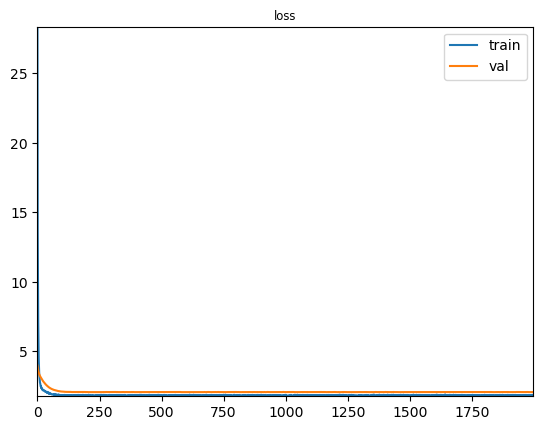

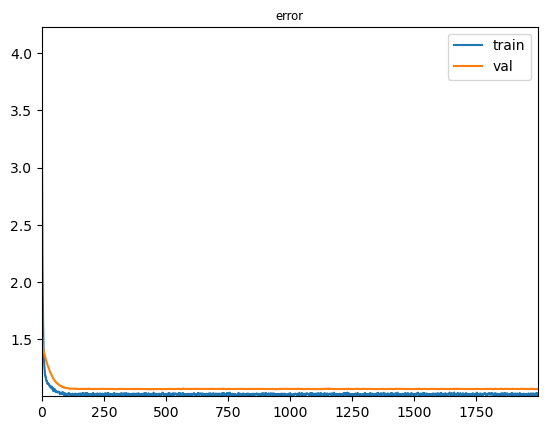

In [30]:
till_epoch = -1
# till_epoch = 500

fig, ax = plt.subplots()
ax.plot(tot_train_loss[:till_epoch], label='train')
ax.plot(tot_val_loss[:till_epoch], label='val')
ax.set_title('loss')
ax.legend()


fig, ax = plt.subplots()
ax.plot(tot_train_err[:till_epoch], label='train')
ax.plot(tot_val_err[:till_epoch], label='val')
ax.set_title('error')
ax.legend()

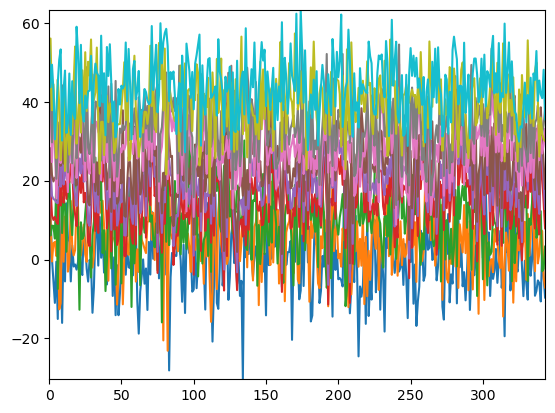

In [28]:
it = iter(train_dataset)
for i in range(10):
    offset = 5*i
    sample = next(it)
    plt.plot(sample[0] + offset)

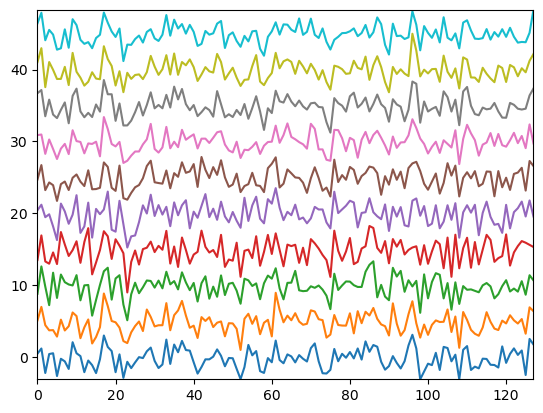

In [61]:
it = iter(train_dataset)
for i in range(10):
    offset = 5*i
    sample = next(it)
    plt.plot(sample[1] + offset)

In [ ]:
# Retrieve embeddings from dataset:
dataset = train_dataset
it = iter(dataset)
samples = []
for _ in range(len(dataset)):
    sample = next(it)
    samples.append(sample[1])  # assuming sample[1] is the tensor of interest
original_embeddings = torch.stack(samples, dim=0).permute(1,0)

original_audio = eu.audio_from_embedding(original_embeddings, scales[0], encodec_model, fs_audio).squeeze(0).squeeze(0)


# SPECTROGRAM
audio_trial = original_audio.detach().numpy()
fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
auts.plot_spectrogram(audio_trial, fs_audio, ax, f_min=500, f_max=8500)
# ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax.set_xlabel('time (s)', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.set_ylabel('f (kHz)', fontsize=30)
ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)

/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/util/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_171461/576027320.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


[Text(0, 0.0, '0'),
 Text(0, 2000.0, '2'),
 Text(0, 4000.0, '4'),
 Text(0, 6000.0, '6'),
 Text(0, 8000.0, '8'),
 Text(0, 10000.0, '')]

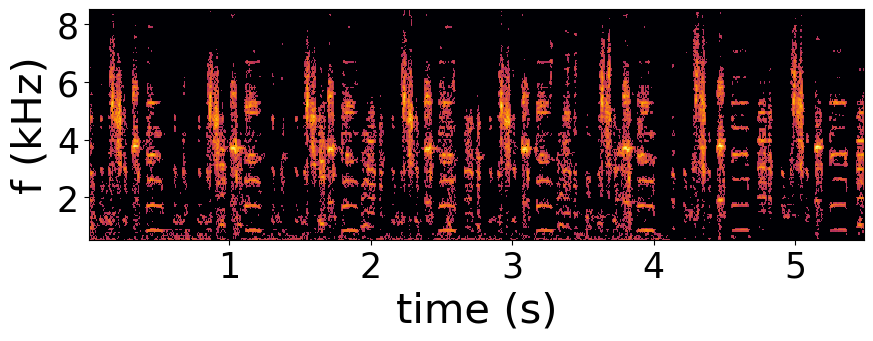

In [90]:
train_dataset = NeuralAudioDataset(train_neural, 
                                   train_audio, 
                                   history_size, 
                                   max_temporal_shift=0,
                                   noise_level=0,
                                   transform_probability=0)
# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

In [91]:
# Decoded embedding
loader = train_loader
# loader = test_loader
decoded_embeddings, error = ffnn_predict(ffnn_model, loader)
decoded_embeddings = decoded_embeddings.permute(1,0)

decoded_audio = eu.audio_from_embedding(decoded_embeddings, scales[0], encodec_model, fs_audio).squeeze(0).squeeze(0)

/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/util/audio_spectrogram_utils.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_171461/1333337880.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


[Text(0, 0.0, '0'),
 Text(0, 2000.0, '2'),
 Text(0, 4000.0, '4'),
 Text(0, 6000.0, '6'),
 Text(0, 8000.0, '8'),
 Text(0, 10000.0, '')]

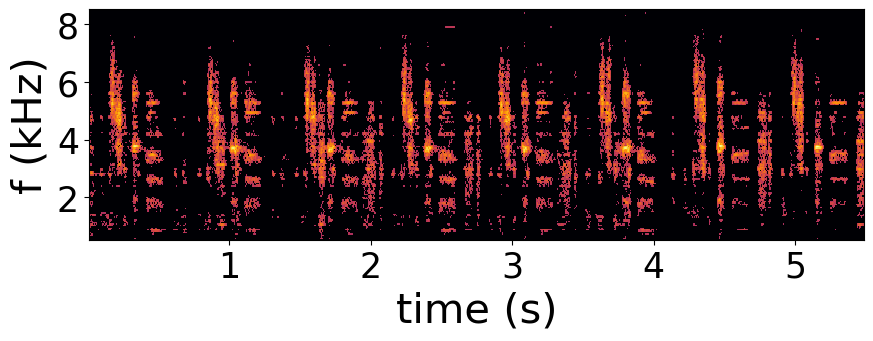

In [92]:
# SPECTROGRAM
audio_trial = decoded_audio.detach().numpy()
fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
auts.plot_spectrogram(audio_trial, fs_audio, ax, f_min=500, f_max=8500)
# ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
ax.set_xlabel('time (s)', fontsize=30)
ax.tick_params(axis='x', labelsize=25)
ax.set_ylabel('f (kHz)', fontsize=30)
ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)

In [85]:
inputs = []
targets = []

# Iterate over motifs and time to extract neural-to-audio_embedding correspondence
for m in range(neural_array.shape[0]):
    for t in range(neural_array.shape[2] - neural_hist_bin):
        # print(neural_array.shape[2], t, t+neural_hist_bin)
        inputs.append(neural_array[m, :, t:t+neural_hist_bin])
        targets.append(audio_embeddings[m, :, t+neural_hist_bin])
        
        # print(neural_array.shape[2], t, neural_array[m, :, t:t+neural_hist_bin].shape)
        # print(audio_embeddings.shape, t, audio_embeddings[m, :, t+neural_hist_bin].shape)

np.array(inputs).shape, np.array(targets).shape

((980, 172, 7), (980, 128))

In [57]:
neural_hist_bin = 7

# Get rid of the starting part of the embeddings, since it won't have a corresponding segment of neural data.
targets = audio_embeddings[:, :, neural_hist_bin:]
# Find corresponding history of neural activity for each spectrogram slice:
inputs = []
for i in range(targets.shape[2]):
    inputs.append(neural_array[:,:, i:i+neural_hist_bin])
inputs = np.array(inputs).transpose(1, 2, 3, 0) # [trials x dimensions x history x samples]

In [58]:
inputs.shape, targets.shape

((10, 172, 7, 98), torch.Size([10, 128, 98]))

In [ ]:
# Regression

# Get rid of the starting part of the embeddings, since it won't have a corresponding segment of neural data.
targets = embeddings_motifs[:, :, neural_samp_hist:]
# Find corresponding history of neural activity for each spectrogram slice:
inputs = []
for i in range(targets.shape[2]):
    inputs.append(neural_array[:,:, i:i+neural_samp_hist])
inputs = np.array(inputs).transpose(1, 2, 3, 0) # [trials x dimensions x history x samples]

# Train, Validation, Test split

# Concatenate motifs (reshape arrays to have dimensions [(features * neural_samp_hist) x trials x samples])
inputs = inputs.transpose(1,2,0,3)
targets = targets.transpose(1,0)
inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], -1)
targets = targets.reshape(targets.shape[0], -1)
# Transpose to (samples * features)
inputs = inputs.transpose(2, 0, 1)
targets = targets.transpose(1, 0)
# Create a DataLoader foar your dataset
input_data = torch.from_numpy(inputs) #torch.randn(10*680, 4650)
output_data = targets #torch.randn(10*680, 112)

# Split the data into training, validation, and testing sets
tot_samples = input_data.shape[0]
train_idx, test_idx = int(0.8*tot_samples), int(0.9*tot_samples)
input_train, output_train = input_data[0:train_idx], output_data[0:train_idx]
input_val, output_val = input_data[train_idx:test_idx], output_data[train_idx:test_idx]
input_test, output_test = input_data[test_idx:], output_data[test_idx:]

# Loaders 
train_dataset = TensorDataset(input_train, output_train)
val_dataset = TensorDataset(input_val, output_val)
test_dataset = TensorDataset(input_test, output_test)

In [ ]:
# --------- TRAIN PARAMS --------- #
batch_size = 10
lr = 0.0005
neural_samp_hist = 9 # neural_ms_hist ~5ms @5ms bins

    
    
    # Regression

    # Get rid of the starting part of the embeddings, since it won't have a corresponding segment of neural data.
    targets = embeddings_motifs[:, :, neural_samp_hist:]
    # Find corresponding history of neural activity for each spectrogram slice:
    inputs = []
    for i in range(targets.shape[2]):
        inputs.append(neural_array[:,:, i:i+neural_samp_hist])
    inputs = np.array(inputs).transpose(1, 2, 3, 0) # [trials x dimensions x history x samples]
    
    # Train, Validation, Test split

    # Concatenate motifs (reshape arrays to have dimensions [(features * neural_samp_hist) x trials x samples])
    inputs = inputs.transpose(1,2,0,3)
    targets = targets.transpose(1,0)
    inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], -1)
    targets = targets.reshape(targets.shape[0], -1)
    # Transpose to (samples * features)
    inputs = inputs.transpose(2, 0, 1)
    targets = targets.transpose(1, 0)
    # Create a DataLoader foar your dataset
    input_data = torch.from_numpy(inputs) #torch.randn(10*680, 4650)
    output_data = targets #torch.randn(10*680, 112)
    
    # Split the data into training, validation, and testing sets
    tot_samples = input_data.shape[0]
    train_idx, test_idx = int(0.8*tot_samples), int(0.9*tot_samples)
    input_train, output_train = input_data[0:train_idx], output_data[0:train_idx]
    input_val, output_val = input_data[train_idx:test_idx], output_data[train_idx:test_idx]
    input_test, output_test = input_data[test_idx:], output_data[test_idx:]
    
    # Loaders 
    train_dataset = TensorDataset(input_train, output_train)
    val_dataset = TensorDataset(input_val, output_val)
    test_dataset = TensorDataset(input_test, output_test)
    
    # --------- TRAIN MODEL --------- #
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Initialize the neural network and optimizer
    input_dim = input_data.shape[1] * input_data.shape[2]
    output_dim = output_data.shape[1]
    ffnn_model = FFNN(input_dim, output_dim)
    
    # Loss function and optimizer
    criterion = nn.MSELoss() 
    optimizer = optim.AdamW(ffnn_model.parameters(), lr=lr)
    
    # Train
    tot_train_loss, tot_train_err, tot_val_loss, tot_val_err = ffnn_train(ffnn_model, train_dataloader, optimizer, criterion, num_epochs, val_dataloader=val_dataloader)
    print('Done training!')
    
    # --------- SAVE MODEL --------- #
    
    models_dir = os.getcwd() + '/models'
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # save the model to disk
    filename = '{}/ffnn_model_binsize{}ms_tpre{:.2f}_tpost{:.2f}_{}_{}_raw_epochs{}_lr{}.pkl'.format(models_dir, binsize, t_pre, t_post, bird, key, num_epochs, lr)
    torch.save({
                'input_dim': input_dim,
                'output_dim': output_dim,
                'neural_samp_hist': neural_samp_hist,
                'epoch': num_epochs,
                'model_state_dict': ffnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_dataloader': train_dataloader,
                'val_dataloader': val_dataloader,
                'test_dataloader': test_dataloader
                }, filename)
    print('model saved: ', filename)

### imports

In [1]:
import sys
import argparse

sys.path.append('/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/')
exec(open('/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/all_imports.py').read())

from FFNNmodel import FFNN, ffnn_predict, ffnn_train, ffnn_evaluate
from decoding_utils import numpy_to_torch, encodec_encode
from decoding_utils import plot_spectrogram
from decoding_utils import resample_by_interpolation_1d, resample_by_interpolation_2d, overlap

## save data

In [2]:
save = False

fig_dir = os.getcwd() + '/paper_figures'
audio_dir = os.getcwd() + '/audio_files'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
if not os.path.exists(audio_dir):
    os.makedirs(audio_dir)

# Load data

In [3]:
sess_par = {'bird': 'z_w12m7_20',
            'date': '2020-11-04',
            'ephys_software': 'sglx',
            'sess': '2500r250a_3500_dir_g0',
            'probe': 'probe_0',
            'sort': 'ksort3_pt',
            }

exp_struct = fs.get_experiment_struct(bird=sess_par['bird'], 
                            date=sess_par['date'], 
                            ephys_software=sess_par['ephys_software'], 
                            sess=sess_par['sess'], 
                            sort=sess_par['sort'])

exp_struct

{'folders': {'bird': '/net2/expData/speech_bci/raw_data/z_w12m7_20',
  'raw': '/net2/expData/speech_bci/raw_data/z_w12m7_20/2020-11-04',
  'sglx': '/net2/expData/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
  'derived': '/net2/expData/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0',
  'sort': '/net2/expData/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/ksort3_pt'},
 'files': {'rig': '/net2/expData/speech_bci/raw_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/rig.json',
  'wav_mic': '/net2/expData/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/wav_mic.wav',
  'sort_params': '/net2/expData/speech_bci/derived_data/z_w12m7_20/2020-11-04/sglx/2500r250a_3500_dir_g0/ksort3_pt/params.py'}}

In [4]:
### kilosort dataframes & behavior 
spike_pickle_path = os.path.join(exp_struct['folders']['sort'], 'spk_df.pkl')
clu_pickle_path = os.path.join(exp_struct['folders']['sort'], 'clu_df_curated.pkl')
mot_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict_curated.pkl')

# Audio
mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.npy')

data = dfpkg.SortDataframe(spike_pickle_path, clu_pickle_path, mot_dict_path, mic_file_name)

# Variables
fs_audio = round(data.fs_audio)
fs_ap = round(data.fs_ap)

clu_df = data.clu_df
spk_df = data.spk_df

audio_dict = data.audio_dict
audio = data.audio

In [5]:
nuclei = ['HVCint', 'ra', 'HVCpn']
qualities = [['SUA1', 'SUA2'], ['SUA3', 'MUA']]
modulations = ['high_spiking', 'low_spiking']

for n in nuclei:
    for q in qualities:
        for m in modulations:
            print(n+' '+str(q)+' '+m+':', len(np.unique(clu_df.loc[(clu_df['quality'].isin(q)) & (clu_df['sub_nucleus']==n) & (clu_df['modulation']==m), 'cluster_id'])))
            

HVCint ['SUA1', 'SUA2'] high_spiking: 40
HVCint ['SUA1', 'SUA2'] low_spiking: 13
HVCint ['SUA3', 'MUA'] high_spiking: 19
HVCint ['SUA3', 'MUA'] low_spiking: 4
ra ['SUA1', 'SUA2'] high_spiking: 93
ra ['SUA1', 'SUA2'] low_spiking: 117
ra ['SUA3', 'MUA'] high_spiking: 2
ra ['SUA3', 'MUA'] low_spiking: 44
HVCpn ['SUA1', 'SUA2'] high_spiking: 6
HVCpn ['SUA1', 'SUA2'] low_spiking: 59
HVCpn ['SUA3', 'MUA'] high_spiking: 2
HVCpn ['SUA3', 'MUA'] low_spiking: 21


In [6]:
# Bird specific params
bird_params = BSP.data['z_w12m7_20']
bird_params

{'len_motif': 0.5,
 'syllable_mapping': {'1': 1,
  '2': 2,
  '3': 3,
  '4': 4,
  '5': 5,
  '6': 9,
  '7': 7,
  'i': 14,
  'I': 10,
  'C': 11,
  'u': 12,
  'B': 8,
  'S': 13}}

### Load annotated labels from TextGrid file

In [7]:
# # Map human-annotated labels to integers
# syllable_mapping = bird_params['syllable_mapping']
# # Annotated Labels
# textgrid_labels_path = os.path.join(exp_struct['folders']['derived'], 'behavior.TextGrid')
# # Audio
# mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.npy')

In [8]:
# txtgrid = luts.TextgridLabels(textgrid_file_path=textgrid_labels_path, audio_file_path=mic_file_name, 
#                               fs_audio=audio_dict['s_f_nidq'], labels_tier='syllables')

# np.unique(txtgrid.labels)

## Audio

In [9]:
data_dir = '/home/jovyan/pablo_tostado/bird_song/manifold_paper_analysis/z_w12m7_20-clean_pipeline/'

file_path = data_dir + '/audio_experiment_z_w12m7_20.pkl'
with open(file_path, 'rb') as pickle_file:
    audio_array = pkl.load(pickle_file)
print("Loaded Audio!")

audio_array

Loaded Audio!


{'audio_array': array([[  579,   123,   294, ..., -1902, -2230,   559],
        [-1679,   377,   464, ...,  1118,  4505,  1850],
        [-1251, -1058,  3487, ...,  -995,  -634,  -406],
        ...,
        [ 1582,  1803,    17, ...,  2012,  1749,   491],
        [ -159,  1249,   791, ...,  1551,  2465,  2288],
        [ 1113,  1142,  -313, ...,  -610,  -665,  -545]]),
 'labels_array': array([[13, 13, 13, ...,  2,  2,  2],
        [ 5,  5,  5, ...,  2,  2,  2],
        [ 5,  5,  5, ...,  8,  8,  8],
        ...,
        [ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ..., 13, 13, 13]]),
 'fs_audio': 25000,
 't_pre': 0.1,
 't_post': 0.6}

In [10]:
data_dir = '/home/jovyan/pablo_tostado/bird_song/manifold_paper_analysis/z_w12m7_20-clean_pipeline/'

file_path = data_dir + '/audio_experiment_z_w12m7_20.pkl'
with open(file_path, 'rb') as pickle_file:
    audio_array = pkl.load(pickle_file)
print("Loaded Audio!")

audio_motifs = audio_array['audio_array']
label_motifs = audio_array['labels_array']
fs_audio = audio_array['fs_audio']

Loaded Audio!


In [11]:
audio_motifs.shape, label_motifs.shape

((10, 17500), (10, 17500))

### Process Audio

#### Filter 250Hz-8000Hz + noisereduce

In [12]:
# Filter audio
b, a = fh.load_filter_coefficients_matlab('/home/jovyan/pablo_tostado/repos/songbirdcore/songbirdcore/filters/butter_bp_250Hz-8000hz_order4_sr25000.mat')

audio_motifs = fh.noncausal_filter_2d(audio_motifs, b=b, a=a)

In [13]:
# Reduce noise
for m in range(len(audio_motifs)):
    audio_motifs[m] = nr.reduce_noise(audio_motifs[m], sr=fs_audio)

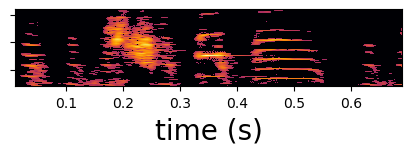

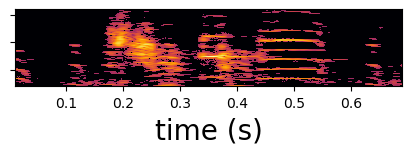

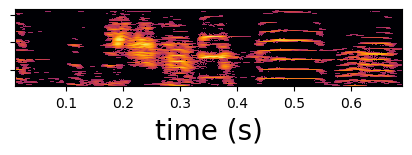

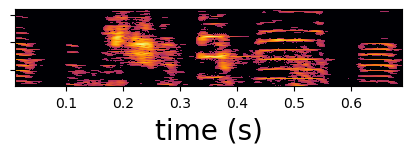

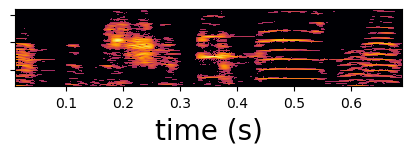

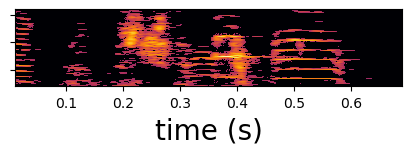

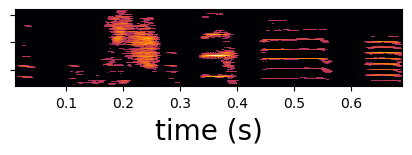

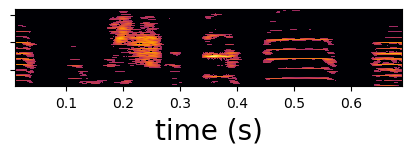

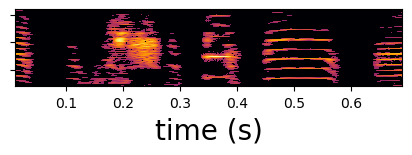

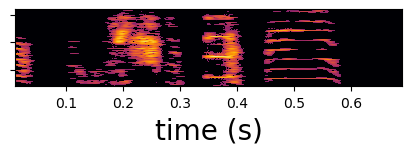

In [14]:
for m in audio_motifs:
    fig, ax = plt.subplots(figsize=(5,1))
    plot_spectrogram(m, fs_audio, ax)

### Generate spiketrains for each nucleus/quality pair

In [15]:
combinations = {
    'ra_sua': ['ra', ['SUA1', 'SUA2'],  'high_spiking'],
    'ra_all': ['ra', ['SUA1', 'SUA2', 'SUA3', 'MUA'], None],
    'hvc_sua': ['hvc', ['SUA1', 'SUA2'], 'high_spiking'],
    'hvc_all': ['hvc', ['SUA1', 'SUA2', 'SUA3', 'MUA'], None]
}

modulation = 'high_spiking'

for k in combinations.keys():
    n = combinations[k][0]
    q = combinations[k][1]
    print('high spike-rate clusters', str(k)+':', len(np.unique(clu_df.loc[(clu_df['quality'].isin(q)) & (clu_df['nucleus']==n) & (clu_df['modulation']==modulation), 'cluster_id'])))
    print('all clusters', str(k)+':', len(np.unique(clu_df.loc[(clu_df['quality'].isin(q)) & (clu_df['nucleus']==n), 'cluster_id'])))

high spike-rate clusters ra_sua: 93
all clusters ra_sua: 210
high spike-rate clusters ra_all: 95
all clusters ra_all: 256
high spike-rate clusters hvc_sua: 46
all clusters hvc_sua: 118
high spike-rate clusters hvc_all: 67
all clusters hvc_all: 164


In [16]:
audio_array

{'audio_array': array([[  -35,  -130,  -127, ..., -1346, -1728,  -340],
        [  331,  1121,   883, ...,   218,  1251,  -542],
        [  285,   456,  2472, ...,  -238,  -202,  -171],
        ...,
        [  -40,  -100,  -838, ...,   395,   375,  -361],
        [   11,   607,   240, ...,  -808,  -429,  -609],
        [  -15,  -210,  -585, ...,    -3,   -15,     1]]),
 'labels_array': array([[13, 13, 13, ...,  2,  2,  2],
        [ 5,  5,  5, ...,  2,  2,  2],
        [ 5,  5,  5, ...,  8,  8,  8],
        ...,
        [ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ...,  9,  9,  9],
        [ 9,  9,  9, ..., 13, 13, 13]]),
 'fs_audio': 25000,
 't_pre': 0.1,
 't_post': 0.6}

In [17]:
# Select time window around the bout
t_pre = audio_array['t_pre']
t_post = audio_array['t_post']

# Retrieve start/end samples in the spiking/audio signals
start_ap = audio_dict['start_sample_ap_0'] - round(fs_ap * t_pre)
end_ap = audio_dict['start_sample_ap_0'] + round(fs_ap * t_post)
start_audio = audio_dict['start_sample_nidq'] - round(fs_audio * t_pre)
end_audio = audio_dict['start_sample_nidq'] + round(fs_audio * t_post)

In [18]:
neural_dict = {}

# Neural arrays
for k in combinations.keys():
    n = combinations[k][0]
    q = combinations[k][1]
    m = combinations[k][2]
    
    print('Processing ', n, q, m)
    
    if m:
        clu_list = np.unique(clu_df.loc[(clu_df['quality'].isin(q)) & (clu_df['nucleus']==n) & (clu_df['modulation']==m), 'cluster_id'])
    else:
        clu_list = np.unique(clu_df.loc[(clu_df['quality'].isin(q)) & (clu_df['nucleus']==n), 'cluster_id'])
    print(len(clu_list))
    
    # Transpose to trials x channels x spiketrain
    neural_dict[k] = data.get_rasters_spikes(clu_list, start_ap, span_samples=int((t_post+t_pre)*fs_ap), clean_raster=False, verbose=True).transpose(2,0,1) 
    
# Audio array
audio_array = np.array(data.get_rasters_audio(start_audio, span_samples=int((t_post+t_pre)*fs_audio)))

# # Labels array
# labels_array = np.array(txtgrid.get_rasters_labels(start_audio, span_samples=int((t_post+t_pre)*fs_audio)))
# # Convert labels to integer values
# labels_array = np.array([[syllable_mapping[x] for x in row] for row in labels_array])

Processing  ra ['SUA1', 'SUA2'] high_spiking
93
Processing  ra ['SUA1', 'SUA2', 'SUA3', 'MUA'] None
256
Processing  hvc ['SUA1', 'SUA2'] high_spiking
46
Processing  hvc ['SUA1', 'SUA2', 'SUA3', 'MUA'] None
164


### Drop silent clusters (at least 1 spike per trial)

In [19]:
for k in neural_dict.keys():
    num_trials = len(neural_dict[k])
    neural_dict[k] = np.delete(neural_dict[k], np.where(np.sum(neural_dict[k], axis=(0,2))<num_trials)[0], axis=1)
    
for k in neural_dict.keys():
    print(k, neural_dict[k].shape)

ra_sua (10, 93, 21000)
ra_all (10, 172, 21000)
hvc_sua (10, 46, 21000)
hvc_all (10, 114, 21000)


In [21]:
# plt.plot(neural_dict['ra_all'][2,0,0:1000000])

In [25]:
key = 'ra_all' 
binsize = 6 # ms
neural_array = neural_dict[key]

number_bin_samples = int(binsize*fs_ap/1000)

# Bin @5ms
neural_array = sh.downsample_list_3d(neural_array, number_bin_samples, mode='sum')
# Apply the square root transform
neural_array = np.sqrt(neural_array)

print(neural_array.shape)

(10, 172, 116)


### Instantiate model from Facebook

In [26]:
# Instantiate a pretrained EnCodec model
# model = EncodecModel.encodec_model_24khz()
encodec_model = EncodecModel.encodec_model_48khz()

# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
encodec_model.set_target_bandwidth(24.0)


In [27]:
embeddings_motifs, codes_motifs, scales = [], [], []

for m in audio_motifs:
    # returns embeddings, codes, scale
    embeddings_motifs.append(encodec_encode(numpy_to_torch(m), fs_audio, encodec_model)[0][0][0]) # embeddings 
    codes_motifs.append(encodec_encode(numpy_to_torch(m), fs_audio, encodec_model)[0][0][1]) # codes
    scales.append(encodec_encode(numpy_to_torch(m), fs_audio, encodec_model)[0][0][2]) # scales

embeddings_motifs = torch.squeeze(torch.stack(embeddings_motifs), 1)
embeddings_motifs.shape

torch.Size([10, 128, 105])

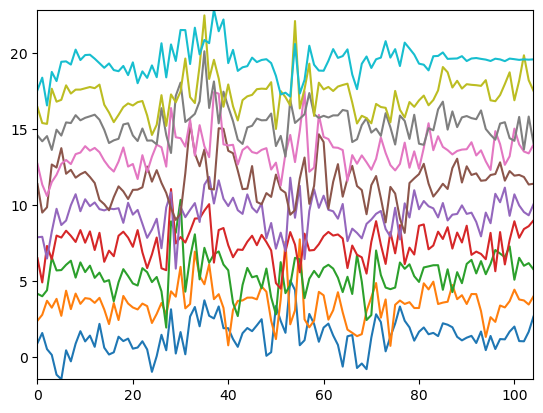

In [28]:
for i in range(len(embeddings_motifs)):
    plt.plot(embeddings_motifs[i,0,:] + 2*i)

In [29]:
scales

[tensor([[2101.6951]]),
 tensor([[2049.2688]]),
 tensor([[2041.4780]]),
 tensor([[2120.9155]]),
 tensor([[2157.4292]]),
 tensor([[1906.6072]]),
 tensor([[1232.5381]]),
 tensor([[1265.6157]]),
 tensor([[1258.0587]]),
 tensor([[954.1398]])]

# Downsample to minimum number of samples

(10, 172, 116)


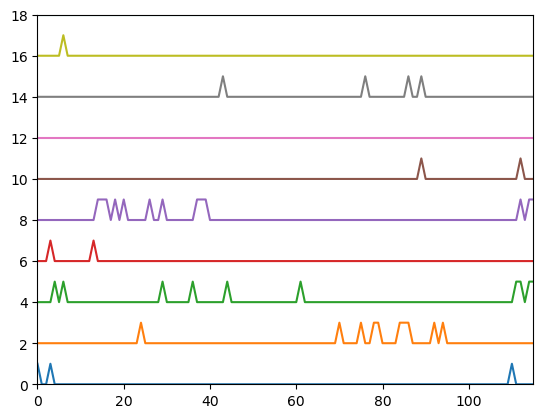

In [30]:
print(neural_array.shape)
for i in range(len(neural_array)):
    plt.plot(neural_array[i,0,:] + 2*i)

In [32]:
print(neural_array.shape, embeddings_motifs.shape)

samples_neural = neural_array.shape[2]
samples_embeddings = embeddings_motifs.shape[2]
print(samples_neural, samples_embeddings)

interp_neural_array = np.array([resample_by_interpolation_2d(n, samples_neural, samples_embeddings) for n in neural_array])

print(interp_neural_array.shape, embeddings_motifs.shape)

(10, 172, 116) torch.Size([10, 128, 105])
116 105
(10, 172, 105) torch.Size([10, 128, 105])


(10, 172, 116)


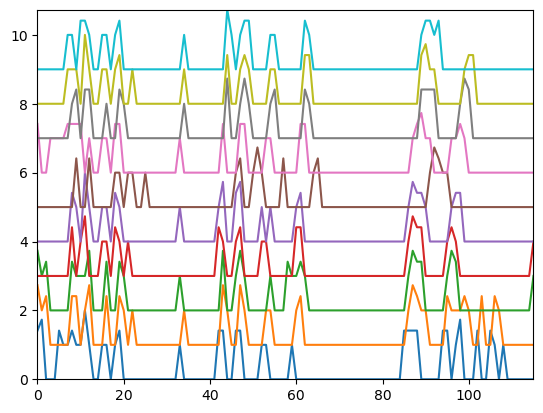

In [36]:
print(neural_array.shape)
for i in range(len(neural_array)):
    plt.plot(neural_array[i,70,:] + i)

# Regression

In [37]:
# Once resampled, the bin size ~ 800ms / 120samples = 6.6ms

# Neural 
neural_samp_hist = 9 # neural_ms_hist ~55ms

# Get rid of the starting part of the embeddings, since it won't have a corresponding segment of neural data.
targets = embeddings_motifs[:, :, neural_samp_hist:]

# Find corresponding history of neural activity for each spectrogram slice:
inputs = []
for i in range(targets.shape[2]):
    inputs.append(neural_array[:,:, i:i+neural_samp_hist])
inputs = np.array(inputs).transpose(1, 2, 3, 0) # [trials x dimensions x history x samples]


print(inputs.shape, targets.shape)

(10, 172, 9, 96) torch.Size([10, 128, 96])


### Train / Test split

In [38]:
# Concatenate motifs (reshape arrays to have dimensions [(features * neural_samp_hist) x trials x samples])

inputs = inputs.transpose(1,2,0,3)
targets = targets.transpose(1,0)

print(inputs.shape, targets.shape)

inputs = inputs.reshape(inputs.shape[0], inputs.shape[1], -1)
targets = targets.reshape(targets.shape[0], -1)

print(inputs.shape, targets.shape)


(172, 9, 10, 96) torch.Size([128, 10, 96])
(172, 9, 960) torch.Size([128, 960])


In [39]:
# Transpose to (samples * features)
inputs = inputs.transpose(2, 0, 1)
targets = targets.transpose(1, 0)

print(inputs.shape, targets.shape)

# Create a DataLoader foar your dataset
input_data = torch.from_numpy(inputs) #torch.randn(10*680, 4650)
output_data = targets #torch.randn(10*680, 112)

print(input_data.shape, output_data.shape)

(960, 172, 9) torch.Size([960, 128])
torch.Size([960, 172, 9]) torch.Size([960, 128])


In [28]:
# Split the data into training, validation, and testing sets

tot_samples = input_data.shape[0]
train_idx, test_idx = int(0.8*tot_samples), int(0.9*tot_samples)

input_train, output_train = input_data[0:train_idx], output_data[0:train_idx]
input_val, output_val = input_data[train_idx:test_idx], output_data[train_idx:test_idx]
input_test, output_test = input_data[test_idx:], output_data[test_idx:]

In [29]:
input_train.shape, input_val.shape, input_test.shape, output_train.shape, output_val.shape, output_test.shape

(torch.Size([768, 172, 9]),
 torch.Size([96, 172, 9]),
 torch.Size([96, 172, 9]),
 torch.Size([768, 128]),
 torch.Size([96, 128]),
 torch.Size([96, 128]))

In [30]:
# Loaders 
train_dataset = TensorDataset(input_train, output_train)
val_dataset = TensorDataset(input_val, output_val)
test_dataset = TensorDataset(input_test, output_test)

# Training FFNN

In [31]:
# Params
batch_size = 10
num_epochs = 8000
lr = 0.0005

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [33]:
input_data.shape

torch.Size([960, 172, 9])

In [34]:
# Initialize the neural network and optimizer
input_dim = input_data.shape[1] * input_data.shape[2]
output_dim = output_data.shape[1]
ffnn_model = FFNN(input_dim, output_dim)

# Define loss function and optimizer
criterion = nn.MSELoss() 
optimizer = optim.AdamW(ffnn_model.parameters(), lr=lr)


In [35]:
# Print the model architecture and number of params
print(ffnn_model)
print('Number of params: ', sum(p.numel() for p in ffnn_model.parameters() if p.requires_grad))

FFNN(
  (fc1): Linear(in_features=1548, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (elu): ELU(alpha=1.0)
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of params:  1881472


In [ ]:
# Extract dict params
input_dim = loaded_dict['input_dim']
output_dim = loaded_dict['output_dim']
neural_samp_hist = loaded_dict['neural_samp_hist']
model_state_dict = loaded_dict['model_state_dict']
train_dataloader = loaded_dict['train_dataloader']
val_dataloader = loaded_dict['val_dataloader']
test_dataloader = loaded_dict['test_dataloader']

In [51]:
def train(model, dataloader, optimizer, criterion, num_epochs, val_dataloader=None):    
    
    # Send model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    model.train()        

    # Initialize empty lists to track losses and errors
    tot_train_loss, tot_train_err = [], []
    tot_val_loss, tot_val_err = [], []
    
    for epoch in range(num_epochs):
            
        train_loss = 0.0
        train_error = 0.0
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)
            # Linearize inputs torch.Size([batch, features, timestamps]) into torch.Size([batch, features*timestamps])
            inputs = inputs.view(inputs.shape[0], -1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_error += mean_absolute_error(targets.view(-1).cpu().numpy(), outputs.view(-1).cpu().detach().numpy())
            
        tot_train_loss.append(train_loss/len(dataloader))
        tot_train_err.append(train_error/len(dataloader))

        # Evaluate
        if val_dataloader:
            val_loss, val_error = evaluate(model, val_dataloader, criterion)
            tot_val_loss.append(val_loss/len(val_dataloader))
            tot_val_err.append(val_error/len(val_dataloader))
        
        # Print progress every 100 epochs
        if (epoch + 1) % 100 == 0:  
            print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {tot_train_loss[-1]}, Training Error: {tot_train_err[-1]}")
            if val_dataloader: print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {tot_val_loss[-1]}, Validation Error: {tot_val_err[-1]}')
    
    return tot_train_loss, tot_train_err, tot_val_loss, tot_val_err
        
        
def evaluate(model, dataloader, criterion):
    
    # Send model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()
    val_loss = 0.0
    val_error = 0.0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)
            # Linearize inputs torch.Size([batch, features, timestamps]) into torch.Size([batch, features*timestamps])
            inputs = inputs.view(inputs.shape[0], -1)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            val_error += mean_absolute_error(targets.view(-1).cpu().numpy(), outputs.view(-1).cpu().detach().numpy())

    return val_loss, val_error



In [37]:
tot_train_loss, tot_train_err, tot_val_loss, tot_val_err = ffnn_train(ffnn_model, train_dataloader, optimizer, criterion, num_epochs, val_dataloader=val_dataloader)
        

Epoch [100/8000] Training Loss: 0.03341203243411207, Training Error: 0.1367484794615151
Epoch [100/8000], Validation Loss: 2.747715231962502, Validation Error: 1.2537821121513844
Epoch [200/8000] Training Loss: 0.0230525466673947, Training Error: 0.11342375909353232
Epoch [200/8000], Validation Loss: 2.57193448767066, Validation Error: 1.214802032026152
Epoch [300/8000] Training Loss: 0.015535264082446501, Training Error: 0.09238438066337015
Epoch [300/8000], Validation Loss: 2.481348702684045, Validation Error: 1.1925913862263162
Epoch [400/8000] Training Loss: 0.015454021578823978, Training Error: 0.09155298924291289
Epoch [400/8000], Validation Loss: 2.395651353523135, Validation Error: 1.1695160263528426
Epoch [500/8000] Training Loss: 0.015501577963496183, Training Error: 0.0923899741141827
Epoch [500/8000], Validation Loss: 2.370869590279957, Validation Error: 1.160464985917012
Epoch [600/8000] Training Loss: 0.01662828035459116, Training Error: 0.09625814535788127
Epoch [600/800

In [43]:
tot_train_loss, tot_train_err, tot_val_loss, tot_val_err = train(ffnn_model, train_dataloader, optimizer, criterion, num_epochs, val_dataloader=val_dataloader)
        

Epoch [100/40000] Training Loss: 0.0320583548300065, Training Error: 0.13459350904086967
Epoch [100/40000], Validation Loss: 2.8203487126156688, Validation Error: 1.267954608425498
Epoch [200/40000] Training Loss: 0.015922912239254294, Training Error: 0.09404620866883885
Epoch [200/40000], Validation Loss: 2.648032939682404, Validation Error: 1.2305361249794562
Epoch [300/40000] Training Loss: 0.019619277617954588, Training Error: 0.10431211935235309
Epoch [300/40000], Validation Loss: 2.5427196035161614, Validation Error: 1.2054922791818778
Epoch [400/40000] Training Loss: 0.014702647912328119, Training Error: 0.09049263857788854
Epoch [400/40000], Validation Loss: 2.433735183129708, Validation Error: 1.177598594687879
Epoch [500/40000] Training Loss: 0.01637891127256217, Training Error: 0.0946363794145646
Epoch [500/40000], Validation Loss: 2.3783274115994573, Validation Error: 1.1614918783307076
Epoch [600/40000] Training Loss: 0.011865342332219536, Training Error: 0.081398336966703

KeyboardInterrupt: 

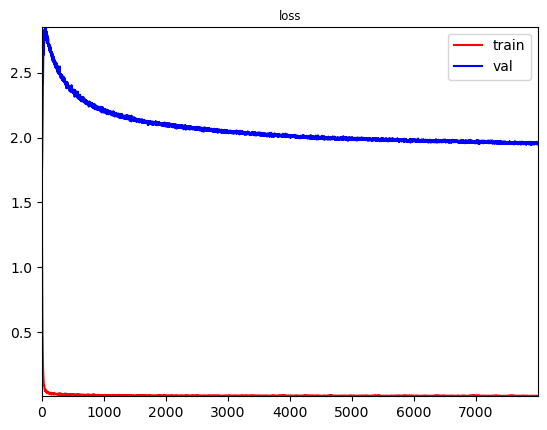

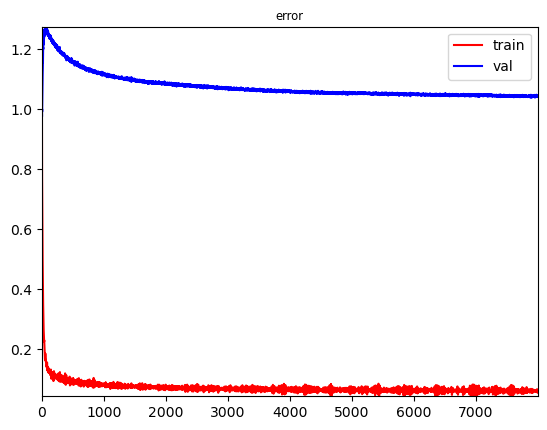

In [40]:
fig, ax = plt.subplots()
ax.plot(tot_train_loss, 'r', label='train')
ax.plot(tot_val_loss, 'b', label='val')
ax.set_title('loss')
ax.legend()


fig, ax = plt.subplots()
ax.plot(tot_train_err, 'r', label='train')
ax.plot(tot_val_err, 'b', label='val')
ax.set_title('error')
ax.legend()


In [41]:
ffnn_model

FFNN(
  (fc1): Linear(in_features=1026, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (elu): ELU(alpha=1.0)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [39]:
# --------- SAVE MODEL --------- #
filename = '/home/jovyan/pablo_tostado/bird_song/decoding_paper_analysis/models/ffnn_model_tpre0.1_tpost0.6_z_w12m7_20_ra_all_raw_epochs4000_lr0.0005.pkl'

torch.save({
            'input_dim': input_dim,
            'output_dim': output_dim,
            'neural_samp_hist': neural_samp_hist,
            'epoch': num_epochs,
            'model_state_dict': ffnn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_dataloader': train_dataloader,
            'val_dataloader': val_dataloader,
            'test_dataloader': test_dataloader
            }, filename)

In [67]:
num_epochs

8000

In [53]:
# Load the checkpoint
checkpoint = torch.load('model_checkpoint.pth')
input_size = checkpoint['input_dim']
output_size = checkpoint['output_dim']

In [54]:
model = FFNN(input_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters())  # Make sure to use the same optimizer and parameters

# Load the model and optimizer state dict
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Reconstruct Spectrograms

In [57]:
# def predict(model, dataloader):
    
#     # Send model to GPU if available
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     model.eval()
    
#     predicted_outputs = []
#     error = []
    
#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)
            
#             if type(loaded_model) == FFNN:
#                 # Linearize inputs torch.Size([batch, features, timestamps]) into torch.Size([batch, features*timestamps])
#                 inputs = inputs.view(inputs.shape[0], -1)
#             outputs = model(inputs)

#             error.append(mean_absolute_error(targets.view(-1).cpu().numpy(), outputs.view(-1).cpu().detach().numpy()))
#             predicted_outputs.append(outputs)
            
#     return torch.cat(predicted_outputs, dim=0), error
#     # return torch.stack(predicted_outputs), error

In [58]:
# Evaluate on:
# mot, dat_load = -2, test_dataloader
mot, dat_load = -2, val_dataloader

In [59]:
# original embedding

EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]
encoded_frames: tp.List[EncodedFrame] = []

original_codes = encodec_model.quantizer.encode(embeddings_motifs[mot, :, neural_samp_hist:].unsqueeze(0), encodec_model.frame_rate, encodec_model.bandwidth)
original_codes = original_codes.transpose(0, 1)
encoded_frames.append((original_codes, scales[mot]))

original_audio = encodec_model.decode(encoded_frames)
original_audio.shape

# Reconvert decoded audio to original sampling rate
model_sr, target_sr = encodec_model.sample_rate, fs_audio
resamp_original_audio = convert_audio(original_audio, model_sr, target_sr, target_channels=1) #[2xN] if model 48kHz

resamp_original_audio.shape

torch.Size([1, 1, 16000])

In [63]:
# Decoded embedding

# prediction = predict(ffn_model, dat_load).permute(1,2,0)
prediction, error = ffnn_predict(ffnn_model, dat_load)
prediction = prediction.unsqueeze(0).permute(0,2,1)

EncodedFrame = tp.Tuple[torch.Tensor, tp.Optional[torch.Tensor]]
encoded_frames: tp.List[EncodedFrame] = []

decoded_codes = encodec_model.quantizer.encode(prediction.to('cpu'), encodec_model.frame_rate, encodec_model.bandwidth)
decoded_codes = decoded_codes.transpose(0, 1)
    
encoded_frames.append((decoded_codes, scales[mot]))

decoded_audio = encodec_model.decode(encoded_frames)
decoded_audio.shape

# Reconvert decoded audio to original sampling rate
model_sr, target_sr = encodec_model.sample_rate, fs_audio
resamp_decoded_audio = convert_audio(decoded_audio, model_sr, target_sr, target_channels=1) #[2xN] if model 48kHz

resamp_decoded_audio.shape

torch.Size([1, 1, 16000])

In [64]:
def plot_spectrogram(signal, sr, axis, n_window=512, step_ms=1, f_min=1000, f_max=8000, cut_off=5.5e-05):
    '''
    Plot spectrogram given a signal and sampling rate (and figure axis).
    '''
    
    f, tm, sxx = sp.ms_spectrogram(signal, sr, n_window=n_window, step_ms=step_ms, f_min=f_min, f_max=f_max, cut_off=cut_off)
    axis.pcolormesh(tm, f, np.log(sxx), cmap='inferno')
    axis.set_axis_off()
    axis.set_ylabel('f (kHz)', fontsize=20)
    axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)

In [65]:
from scipy.io.wavfile import write

write('output.wav', fs_audio, np.int16(resamp_original_audio.squeeze(0).squeeze(0).detach().numpy()))
write('hvc-decoded.wav', fs_audio, np.int16(resamp_decoded_audio.squeeze(0).squeeze(0).detach().numpy()))

/tmp/ipykernel_48886/3656261154.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_48886/3656261154.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


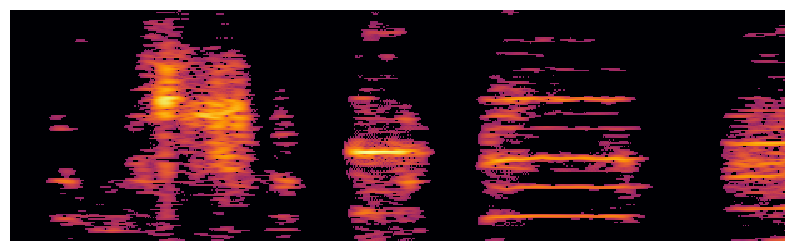

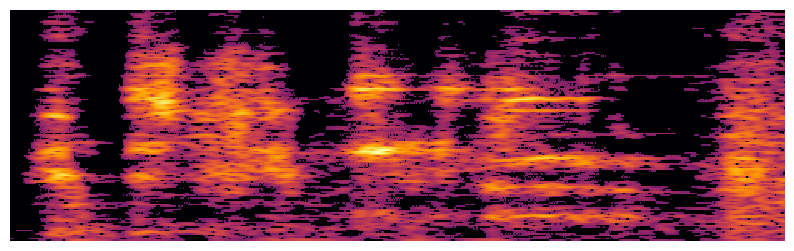

In [66]:
# fig, ax = plt.subplots(2,1, figsize=(10,6))

fig, ax = plt.subplots(figsize=(10,3))
plot_spectrogram(resamp_original_audio.squeeze(0).squeeze(0).detach().numpy(), fs_audio, ax)
# ax[0].set_title('Original')

fig, ax = plt.subplots(figsize=(10,3))
plot_spectrogram(resamp_decoded_audio.squeeze(0).squeeze(0).detach().numpy(), fs_audio, ax)
# ax[1].set_title('Decoded')

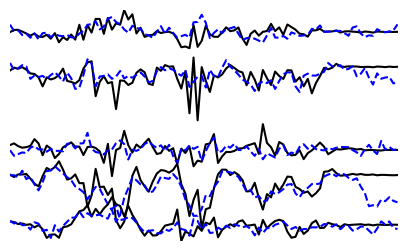

In [76]:
fig, ax = plt.subplots(figsize=(5,3))

scale = 7

for c in range(5):
    ax.plot(embeddings_motifs[-1, :, neural_samp_hist:].unsqueeze(0)[0, c, :]-c*scale, 'k')
    ax.plot(prediction[0, c, :].to('cpu')-c*scale, 'b--')
    ax.set_axis_off()

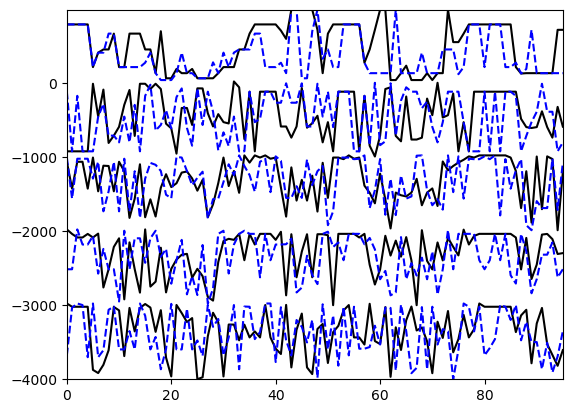

In [77]:
scale=1000

for c in range(5):
    plt.plot(original_codes[0, c, :]-c*scale, 'k')
    plt.plot(decoded_codes[0, c, :]-c*scale, 'b--')

In [78]:
# save = False

# if save == True: 
#     models_dir = os.getcwd() + '/models'

#     if not os.path.exists(models_dir):
#         os.makedirs(models_dir)

#     # save the model to disk
#     filename = models_dir + '/ffnn_model_HVCtrajectories_' + 'epochs' + str(num_epochs) + '_lr' + str(lr) + '.pkl'
#     pkl.dump(ffn_model, open(filename, 'wb'))
    

In [98]:
# models_dir = os.getcwd() + '/models'
# filename = models_dir + '/ffnn_model_RAtrajectories_epochs40000_lr0.0005.pkl'

# # Load model from pickle
# loaded_model = pkl.load(open(filename, 'rb'))

In [99]:
# save = False

# if save == True: 
#     models_dir = os.getcwd() + '/models'

#     if not os.path.exists(models_dir):
#         os.makedirs(models_dir)

#     # save the model to disk
#     filename = models_dir + '/save_loaders' + '.pkl'
#     pkl.dump(ffn_model, open(filename, 'wb'))

In [91]:
print('Number of params: ', sum(p.numel() for p in ffnn_model.parameters() if p.requires_grad))
num_params = sum(p.numel() for p in ffnn_model.parameters() if p.requires_grad)

Number of params:  1881472


In [92]:
save = True

if save == True: 
    models_dir = os.getcwd() + '/models_statedict'

    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
        
    # save the model's state dict
    filename = models_dir + '/ffnn_model_RAall-sqrt_' + 'num_params' + str(num_params) + '_epochs' + str(num_epochs) + '_lr' + str(lr) + '.pkl'

    torch.save({
                'input_dim': input_dim,
                'output_dim': output_dim,
                'neural_samp_hist': neural_samp_hist,
                'epoch': num_epochs,
                'model_state_dict': ffnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_dataloader': train_dataloader,
                'val_dataloader': val_dataloader,
                'test_dataloader': test_dataloader
                }, filename)

In [ ]:
pd_trajectories = pd.DataFrame([], columns = ['factor' + str(x) for x in range(len(trajectories[0]))] + ['motif'])

for mot in range(len(trajectories)):
    df = pd.DataFrame(trajectories[mot].T, columns = ['factor' + str(x) for x in range(len(trajectories[mot]))])
    df['motif'] = mot
    pd_trajectories = pd.concat([pd_trajectories, df], ignore_index = True)
    
pd_trajectories

factor0   factor1   factor2   factor3   factor4   factor5   factor6  \
0    -0.019117 -0.299110  1.560633  0.075272  0.017992 -0.104511 -0.239716   
1     0.122447 -0.511166  1.125624  0.202307  0.182176 -0.048677 -0.278310   
2     0.115177 -0.433578  0.882044  0.298393  0.290206  0.164679 -0.067094   
3    -0.100963 -0.222343  0.715088  0.161513  0.416285 -0.186837  0.176117   
4    -0.318815 -0.400877  0.814212  0.067823  0.341530 -0.620622  0.199727   
...        ...       ...       ...       ...       ...       ...       ...   
1585 -0.311067 -0.404168 -0.663680 -0.492208  0.496997  0.279325 -0.057904   
1586 -0.294938 -0.410415 -0.669162 -0.441622  0.541072  0.329842 -0.082067   
1587 -0.264342 -0.399798 -0.613280 -0.418322  0.536609  0.311890 -0.098869   
1588 -0.243416 -0.359158 -0.599294 -0.512896  0.470396  0.297562 -0.140801   
1589 -0.270134 -0.400853 -0.624316 -0.529063  0.482521  0.229115 -0.120804   

       factor7   factor8   factor9  ...  factor15  factor16  factor17  \
0    -0.218850  0.467042 -0.169992  ... -0.416147  0.669849 -0.408705   
1    -0.631997  0.586387 -0.094643  ... -0.463094  0.614776 -0.427285   
2    -0.648777  0.606089 -0.185968  ... -0.102647  0.681852 -0.270621   
3    -0.177297  0.309707 -0.094775  ...  0.529498  0.646575  0.026596   
4     0.161880  0.321843  0.082277  ...  0.730552  0.520898  0.113173   
...        ...       ...       ...  ...       ...       ...       ...   
1585  0.316981  0.354677  0.398114  ... -0.151235  0.184903  0.117891   
1586  0.288510  0.384162  0.358933  ... -0.175813  0.185059  0.111849   
1587  0.304128  0.422707  0.295391  ... -0.199131  0.192801  0.125837   
1588  0.316807  0.383359  0.334869  ... -0.205868  0.184794  0.159293   
1589  0.276793  0.357176  0.334227  ... -0.202815  0.102905  0.122659   

      factor18  factor19  factor20  factor21  factor22  factor23  motif  
0    -0.028060  0.204636  0.189991 -0.117312 -0.029286  0.037877      0  
1    -0.054582  0.135821  0.273053 -0.008897  0.058345  0.082835      0  
2     0.135389  0.212915  0.318141  0.003373  0.039322  0.081843      0  
3     0.544408  0.518142  0.410403 -0.022591 -0.005661  0.098400      0  
4     0.754692  0.719836  0.435174 -0.030175  0.027828  0.109631      0  
...        ...       ...       ...       ...       ...       ...    ...  
1585  0.152792 -0.107035 -0.169862  0.000197 -0.015287  0.288166      9  
1586  0.149193 -0.140775 -0.126954  0.036104 -0.020315  0.296809      9  
1587  0.131501 -0.164034 -0.104261  0.053113 -0.055259  0.302394      9  
1588  0.128731 -0.145857 -0.123832  0.036807 -0.100187  0.284763      9  
1589  0.118634 -0.154648 -0.114189  0.052281 -0.075962  0.282962      9  

[1590 rows x 25 columns]

In [ ]:
pd_trajectory_labels = pd.DataFrame([], columns = ['label'] + ['motif'])

for mot in range(len(label_motifs)):

    df = pd.DataFrame(label_motifs[mot], columns = ['label'])
    df['motif'] = mot
    pd_trajectory_labels = pd.concat([pd_trajectory_labels, df], ignore_index = True)
    
pd_trajectory_labels

label motif
0         13     0
1         13     0
2         13     0
3         13     0
4         13     0
...      ...   ...
199995    13     9
199996    13     9
199997    13     9
199998    13     9
199999    13     9

[200000 rows x 2 columns]

In [ ]:
save = False

In [ ]:
if save == True:

    # write("example.wav", sr, y.astype(np.int16))
    file = 'motif' + str(motif)

    # Save original audio 
    out_f = audio_dir + '/original_' + file + '.wav'
    wav_original = wav[0,:].detach().numpy() 
    samp_rate = sr
    wavf.write(out_f, sr, wav_original.astype(np.int16))

    # Save original (re-sampled) audio 
    out_f = audio_dir + '/resampled_' + file + '.wav'
    # Pick mono-channel to plot spectrogram and convert to numpy.array
    wav_resampled = resamp_wav[0,0,:].detach().numpy() 
    samp_rate = model.sample_rate
    wavf.write(out_f, samp_rate, wav_resampled.astype(np.int16)) 

    # Save decompressed audio 
    out_f = audio_dir + '/resampled_' + file + '_decompressed.wav'
    # Pick mono-channel to plot spectrogram and convert to numpy.array
    wav_decompressed = decoded_audio[0,0,:].detach().numpy()
    samp_rate = model.sample_rate
    wavf.write(out_f, samp_rate, wav_decompressed.astype(np.int16))

    # Save decompressed audio 
    out_f = audio_dir + '/original_' + file + '_decompressed.wav'
    # Pick mono-channel to plot spectrogram and convert to numpy.array
    wav_resamp_decompressed = resamp_decoded_audio[0,0,:].detach().numpy()
    samp_rate = sr
    wavf.write(out_f, samp_rate, wav_resamp_decompressed.astype(np.int16))

/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


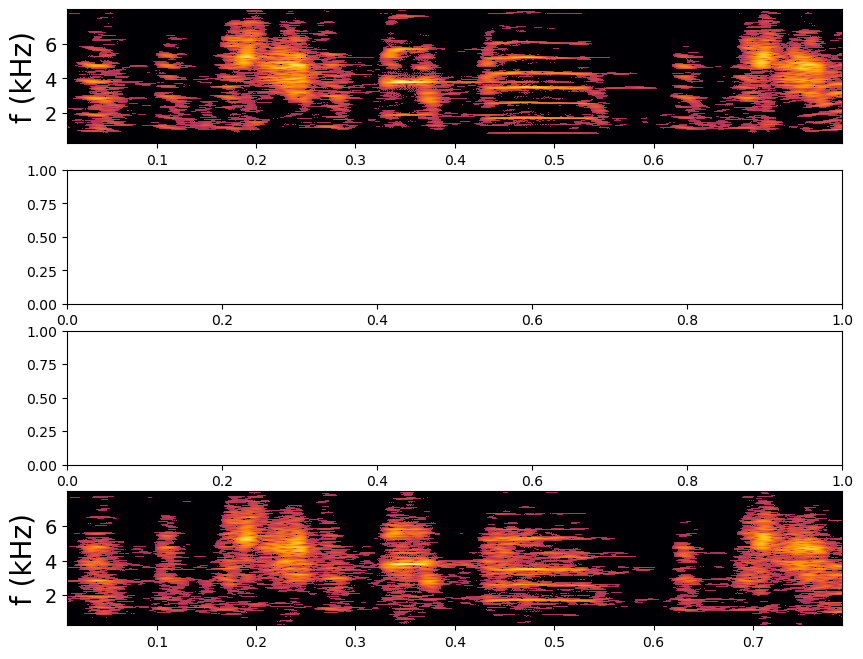

In [ ]:
f_min, f_max = 250, 8000

# Plot original and decoded spectrogram
fig, ax = plt.subplots(4, 1, figsize=(10, 8))

# ORIGINAL spectrogram
# test_wav = fh.noncausal_filter_1d(wav[0], b=b1000, a=a1000)
plot_spectrogram(wav[0], sr, ax[0], f_min=f_min, f_max=f_max)

# (RE-SAMPLED) ORIGINAL spectrogram
# plot_spectrogram(resamp_wav[0,0], model.sample_rate, ax[1], f_min=f_min, f_max=f_max)

# # DECODED spectrogram
# plot_spectrogram(decoded_audio[0,0].detach().numpy(), model.sample_rate, ax[2], f_min=f_min, f_max=f_max)

# DECODED spectrogram resampled to ORIGINAL sr
plot_spectrogram(resamp_decoded_audio[0,0].detach().numpy(), sr, ax[3], f_min=f_min, f_max=f_max)

if save == True:
    # ORIGINAL spectrogram
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    plot_spectrogram(wav[0], sr, ax)
    fig.savefig(fig_dir + '/original_bout.svg', format='svg', bbox_inches = 'tight', dpi=1000, transparent=True)
    fig.savefig(fig_dir + '/original_bout.jpg', format='jpg', bbox_inches = 'tight', dpi=1000, transparent=True)

    # DECODED spectrogram resampled to ORIGINAL sr
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    plot_spectrogram(resamp_decoded_audio[0,0].detach().numpy(), sr, ax)
    fig.savefig(fig_dir + '/encodec_decoded_bout.svg', format='svg', bbox_inches = 'tight', dpi=1000, transparent=True)
    fig.savefig(fig_dir + '/encodec_decoded_bout.jpg', format='jpg', bbox_inches = 'tight', dpi=1000, transparent=True)

### Instantiate model from HuggingFace

In [ ]:
from transformers import EncodecModel, EncodecConfig, AutoProcessor
from encodec.utils import convert_audio

In [ ]:
y = traj_dict['audio_motifs'][motif]

(275000,) <class 'numpy.ndarray'> 25000


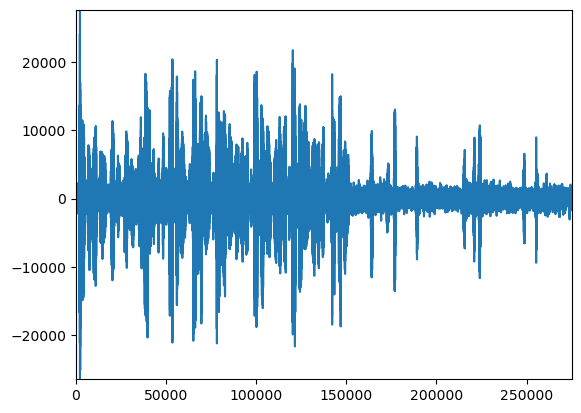

In [ ]:
print(y.shape, type(y), sr)

plt.plot(y)

( target_bandwidths = [1.5, 3.0, 6.0, 12.0, 24.0]sampling_rate = 24000audio_channels = 1normalize = Falsechunk_length_s = Noneoverlap = Nonehidden_size = 128num_filters = 32num_residual_layers = 1upsampling_ratios = [8, 5, 4, 2]norm_type = 'weight_norm'kernel_size = 7last_kernel_size = 7residual_kernel_size = 3dilation_growth_rate = 2use_causal_conv = Truepad_mode = 'reflect'compress = 2num_lstm_layers = 2trim_right_ratio = 1.0codebook_size = 1024codebook_dim = Noneuse_conv_shortcut = True**kwargs )

In [ ]:
fh.noncausal_filter_1d??

Signature: fh.noncausal_filter_1d(signal, b, a=1)
Docstring: <no docstring>
Source:   
def noncausal_filter_1d(signal, b, a=1):
    y = filtfilt(b, a, signal)
    return y
File:      /home/jovyan/pablo_tostado/src/spikefinder/spikefinder/filtering_helper.py
Type:      function


In [ ]:
wav = arr_to_torch_tensor(y)

print(wav.shape, type(wav), y.shape, type(y))

torch.Size([1, 275000]) <class 'torch.Tensor'> (275000,) <class 'numpy.ndarray'>


In [ ]:
zz = fh.noncausal_filter_1d(y, b1000, a1000)

wav = arr_to_torch_tensor(zz.copy())

print(wav.shape, type(wav), zz.shape, type(zz))

torch.Size([1, 275000]) <class 'torch.Tensor'> (275000,) <class 'numpy.ndarray'>


In [ ]:
zz

array([ -13.4627254 , -108.40492951, -114.00477612, ...,   48.69541553,
         88.46301897,   -9.93759458])

In [ ]:
y

array([ 191, -125,  -47, ..., -459, -499, -538])

In [ ]:
arr_to_torch_tensor??

Signature: arr_to_torch_tensor(X: <built-in function array>)
Source:   
def arr_to_torch_tensor(X: np.array):
    '''
    Convert numpy array (N,) to expanded float torch tensor [1xN]. E.g. to feed to EncoDec 
    '''
    
    X = torch.from_numpy(X)
    X = X.expand(1, -1)
    X = X.to(torch.float)
    return X
File:      /tmp/ipykernel_6147/1494091283.py
Type:      function


In [ ]:
# configuration = EncodecConfig(
#     audio_channels = 1,
#     chunk_length_s = None,
#     overlap = None,
#     target_bandwidths = [1.5, 3.0, 6.0, 12.0, 24.0],
#     sampling_rate = sr,
#     codebook_size = 1024,
#     codebook_dim = None
# )

# model = EncodecModel(configuration)
model = EncodecModel.from_pretrained("facebook/encodec_48khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_48khz")

# Avoid overlapping:
model.config.overlap = 0
processor.overlap = 0

# display(model.config)

wav = arr_to_torch_tensor(zz.copy())

# Interpolate audio to desired model sample_rate / n_channels:
original_sr, target_sr = sr, model.config.sampling_rate
audio = convert_audio(wav, original_sr, target_sr, model.config.audio_channels) #[2xN] if model 48kHz
inputs = processor(raw_audio=audio, sampling_rate=processor.sampling_rate, return_tensors="pt")


print(wav.shape, audio.shape, inputs['input_values'][0].shape, inputs["padding_mask"].shape)


# Encode and Decode
encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"], bandwidth=24.0)
audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio, inputs["padding_mask"])[0]



Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


torch.Size([1, 275000]) torch.Size([2, 528000]) torch.Size([2, 528000]) torch.Size([1, 528000])


audio_codes
audio_scales
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([1, 16, 150])
torch.Size([16, 1650])


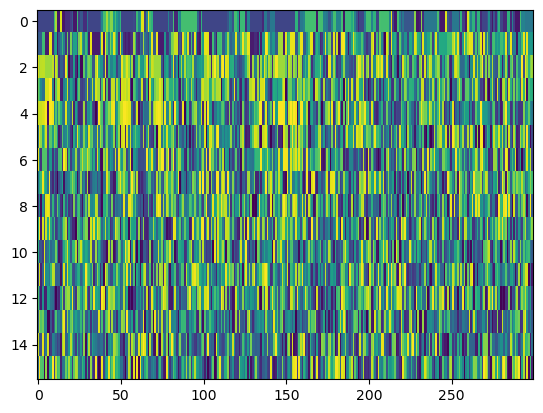

In [ ]:
# Look at codes
for encoded in encoder_outputs:
    print(encoded)
    
for encoded in encoder_outputs.audio_codes:
    print(encoded.shape)

codes = torch.cat([encoded[0] for encoded in encoder_outputs.audio_codes], dim=-1)  # [B, n_q, T]: B=1, n_q = #codebooks (16 for 24bps), T = encoded TimeSeq
print(codes.shape)
im_codes = np.squeeze(codes)
plt.imshow(im_codes[:, 0:300], interpolation='nearest', aspect='auto')

torch.Size([1, 1, 275000])


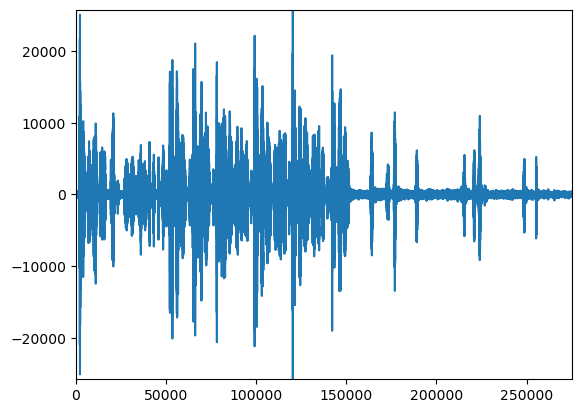

In [ ]:
# Reconvert decoded audio to original sampling rate
model_sr, target_sr = model.config.sampling_rate, sr 
resamp_decoded_audio = convert_audio(audio_values, model_sr, target_sr, target_channels=1) #[2xN] if model 48kHz

print(resamp_decoded_audio.shape)
plt.plot(np.squeeze(resamp_decoded_audio.detach().numpy()))

#### Save decompressed WAV file

In [ ]:
print(wav.shape, resamp_wav.shape, decoded_audio.shape, resamp_decoded_audio.shape)

NameError: name 'resamp_wav' is not defined

In [ ]:
save = False

In [ ]:
if save == True:

    # write("example.wav", sr, y.astype(np.int16))
    file = 'motif' + str(motif)

    # Save original audio 
    out_f = audio_dir + '/original_' + file + '.wav'
    wav_original = wav[0,:].detach().numpy() 
    samp_rate = sr
    wavf.write(out_f, sr, wav_original.astype(np.int16))

    # Save original (re-sampled) audio 
    out_f = audio_dir + '/resampled_' + file + '.wav'
    # Pick mono-channel to plot spectrogram and convert to numpy.array
    wav_resampled = resamp_wav[0,0,:].detach().numpy() 
    samp_rate = model.sample_rate
    wavf.write(out_f, samp_rate, wav_resampled.astype(np.int16)) 

    # Save decompressed audio 
    out_f = audio_dir + '/resampled_' + file + '_decompressed.wav'
    # Pick mono-channel to plot spectrogram and convert to numpy.array
    wav_decompressed = decoded_audio[0,0,:].detach().numpy()
    samp_rate = model.sample_rate
    wavf.write(out_f, samp_rate, wav_decompressed.astype(np.int16))

    # Save decompressed audio 
    out_f = audio_dir + '/original_' + file + '_decompressed.wav'
    # Pick mono-channel to plot spectrogram and convert to numpy.array
    wav_resamp_decompressed = resamp_decoded_audio[0,0,:].detach().numpy()
    samp_rate = sr
    wavf.write(out_f, samp_rate, wav_resamp_decompressed.astype(np.int16))

/tmp/ipykernel_6147/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_6147/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


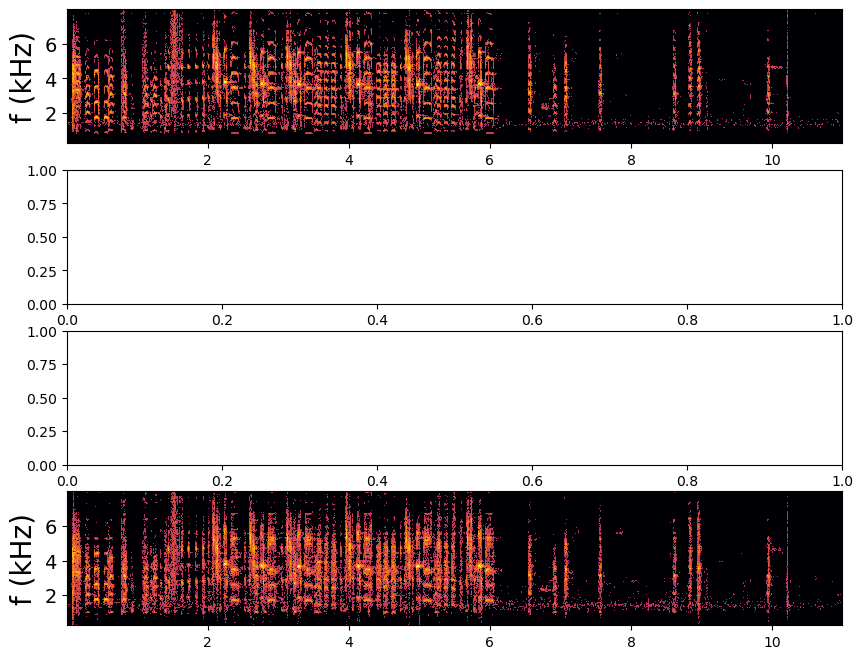

In [ ]:
f_min, f_max = 250, 8000

# Plot original and decoded spectrogram
fig, ax = plt.subplots(4, 1, figsize=(10, 8))

# ORIGINAL spectrogram
# test_wav = fh.noncausal_filter_1d(wav[0], b=b1000, a=a1000)
plot_spectrogram(wav[0], sr, ax[0], f_min=f_min, f_max=f_max)

# (RE-SAMPLED) ORIGINAL spectrogram
# plot_spectrogram(resamp_wav[0,0], model.sample_rate, ax[1], f_min=f_min, f_max=f_max)

# # DECODED spectrogram
# plot_spectrogram(decoded_audio[0,0].detach().numpy(), model.sample_rate, ax[2], f_min=f_min, f_max=f_max)

# DECODED spectrogram resampled to ORIGINAL sr
plot_spectrogram(resamp_decoded_audio[0,0].detach().numpy(), sr, ax[3], f_min=f_min, f_max=f_max)

if save == True:
    # ORIGINAL spectrogram
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    plot_spectrogram(wav[0], sr, ax)
    fig.savefig(fig_dir + '/original_bout.svg', format='svg', bbox_inches = 'tight', dpi=1000, transparent=True)
    fig.savefig(fig_dir + '/original_bout.jpg', format='jpg', bbox_inches = 'tight', dpi=1000, transparent=True)

    # DECODED spectrogram resampled to ORIGINAL sr
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    plot_spectrogram(resamp_decoded_audio[0,0].detach().numpy(), sr, ax)
    fig.savefig(fig_dir + '/encodec_decoded_bout.svg', format='svg', bbox_inches = 'tight', dpi=1000, transparent=True)
    fig.savefig(fig_dir + '/encodec_decoded_bout.jpg', format='jpg', bbox_inches = 'tight', dpi=1000, transparent=True)

## Metrics: compare 2 spectrograms

In [ ]:
def normalize_array(p):
    '''
    Normalize np.array (p). 
    
    Used to normalize concatenated spectrograms to account for variations among motifs from different bouts/birds.
    the collection of original spectrograms for each bird had a maximum power of 1 and minimum power of 0.
    pmax/pmin denotes the maximum/minimum power of the entire set of original spectrograms.
    
    Account for variations among motifs from different bouts/birds while keeping the variations within motifs from the same bout/bird.
    '''
    pmin, pmax = np.min(p), np.max(p)
    p -= pmin
    p /= (pmax-pmin)
    return(p)

def spectrograms_RMSE(w1, w2, sr): 
    '''
    Root Mean Square Error between two spectrograms.
    '''
    
    # warning: if signals have different length spectrograms will have different dimension.
    # This function compares the corresponding beginning of the signals
    if len(w1) != len(w2):
        warnings.warn('Signals have different lengths. Comparison will be made with the beginning of each.', UserWarning)
    l = np.min([len(w1), len(w2)])
    
    # Calculate spectrograms
    f1, tm1, sxx1 = sp.ms_spectrogram(w1[0:l], sr)
    f2, tm2, sxx2 = sp.ms_spectrogram(w2[0:l], sr)
    
    RMSE = math.sqrt(mean_squared_error(normalize_array(sxx1), normalize_array(sxx2)))
    return RMSE

def spectrograms_diff(w1, w2, sr):
    '''
    Returns the L2 (Frobenius norm) of the diff matrix between 2 spectrograms.
    The Frobenius norm is given by: ||A||_F = [\\sum_{i,j} abs(a_{i,j})^2]^{1/2}
    '''
    
    # warning: if signals have different length spectrograms will have different dimension.
    # This function compares the corresponding beginning of the signals
    if len(w1) != len(w2):
        warnings.warn('Signals have different lengths. Comparison will be made with the beginning of each.', UserWarning)
    l = np.min([len(w1), len(w2)])
    
    # Plot spectrograms
    # fig, ax = plt.subplots(2, 1, figsize=(5, 8))
    # plot_spectrogram(w1, sr, ax[0])
    # plot_spectrogram(w2, sr, ax[1])
    
    f1, tm1, sxx1 = sp.ms_spectrogram(w1[0:l], sr)
    f2, tm2, sxx2 = sp.ms_spectrogram(w2[0:l], sr)
    
    d = np.linalg.norm(np.abs(sxx1-sxx2), ord='fro')
    
    # take the absolute difference of the images
    res = cv2.absdiff(sxx1, sxx2)
    # convert the result to integer type
    res = res.astype(np.uint8)
    # find percentage difference/similarity based on number of pixels that are not zero
    per_diff = (np.count_nonzero(res) * 100)/ res.size
    per_similarity = 100-per_diff
    
    d2 = np.linalg.norm(res, ord='fro')

    return sxx1, sxx2, d, per_similarity, d2

In [ ]:
# from encodec.utils import convert_audio

target_bandwidths = [3, 6, 12, 24]
    
# Instantiate a pretrained EnCodec model
# model = EncodecModel.encodec_model_24khz()
model = EncodecModel.encodec_model_48khz()
wav = arr_to_torch_tensor(y.copy()) #[1xN]

code_num = []
spec_rmse = []
decoded_wav = []
    
for bw in target_bandwidths:

    # For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
    # of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
    model.set_target_bandwidth(bw)

    # Convert to expanded float torch tensor:
    wav = arr_to_torch_tensor(y.copy()) #[1xN]

    # Encode audio
    encoded_frames, resamp_wav = audio_codes_encodec_fb(wav, sr, model)
    codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]: B=1, n_q = #codebooks (16 for 24bps), T = encoded TimeSeq
    code_num.append(codes.shape[1])

    # Decode audio from latents
    decoded_audio = model.decode(encoded_frames)

    # Reconvert decoded audio to original sampling rate
    model_sr, target_sr = model.sample_rate, sr 
    resamp_decoded_audio = convert_audio(decoded_audio, model_sr, target_sr, target_channels=1) #[2xN] if model 48kHz
    decoded_wav.append(resamp_decoded_audio[0,0].detach().numpy())
    
    s1 = normalize_array(pretty_spectrogram(wav[0]))
    s2 = normalize_array(pretty_spectrogram(resamp_decoded_audio[0,0].detach().numpy()))

    spec_rmse.append(math.sqrt(mean_squared_error(s1, s2)))

/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


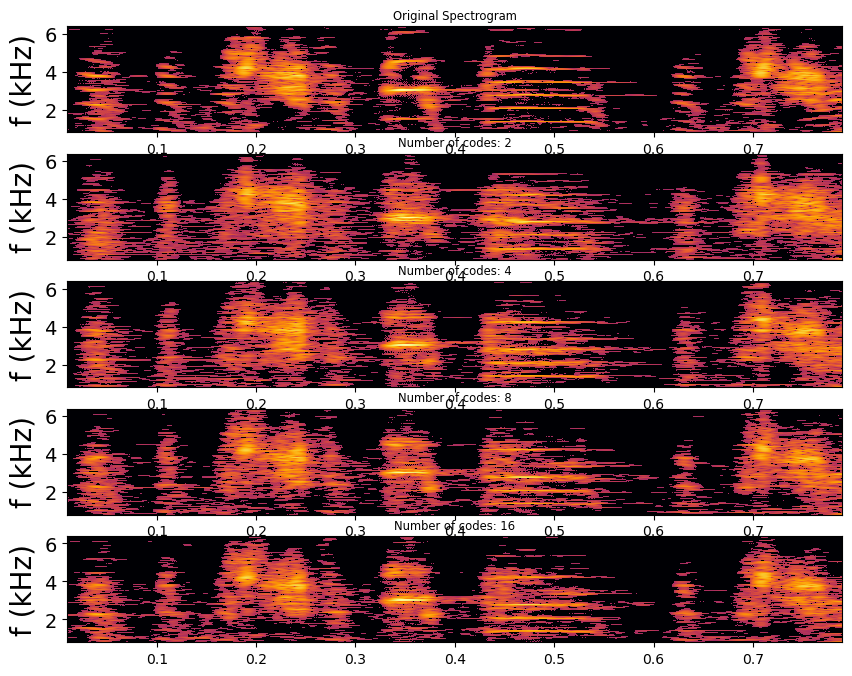

In [ ]:
f_min, f_max = 1000, 8000

# Plot original and decoded spectrogram
fig, ax = plt.subplots(5, 1, figsize=(10, 8))
ax[0].set_title('Original Spectrogram')

# ORIGINAL spectrogram
plot_spectrogram(wav[0], sr, ax[0], f_min=f_min, f_max=f_max)

# Decoded Spectrograms spectrogram
for w in range(len(decoded_wav)):
    plot_spectrogram(decoded_wav[w], sr, ax[w+1], f_min=f_min, f_max=f_max)
    ax[w+1].set_title('Number of codes: ' + str(code_num[w]))

In [ ]:
data

codes      rmse
0      2  0.146517
1      4  0.130126
2      8  0.123011
3     16  0.116440

(0.1047956108320919, 0.16116823681660297)

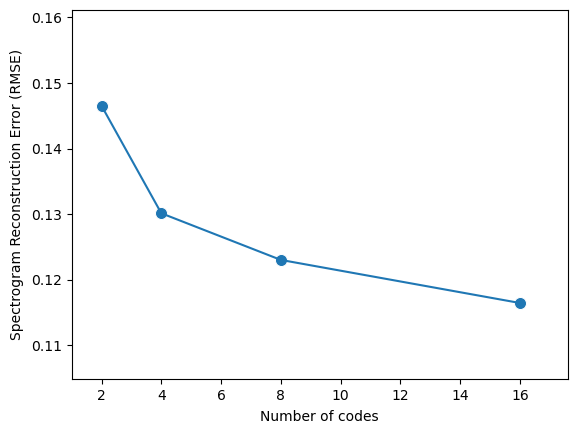

In [ ]:
data = pd.DataFrame({'codes':code_num, 'rmse':spec_rmse})

fig, ax = plt.subplots()
sns.scatterplot(data, x='codes', y='rmse', s=75)
plt.plot(data['codes'], data['rmse'])
ax.set(xlabel='Number of codes', ylabel='Spectrogram Reconstruction Error (RMSE)')

ax.set_xlim(xmin=ax.get_xlim()[0]-0.5*ax.get_xlim()[0], xmax=ax.get_xlim()[1]+0.1*ax.get_xlim()[1])
ax.set_ylim(ymin=ax.get_ylim()[0]-0.1*ax.get_ylim()[0], ymax=ax.get_ylim()[1]+0.1*ax.get_ylim()[1])

## pandas dataframe with encodec targets

The pre-trained model encodes segments of 1s with 10% overlap. Therefore, running a single model on concatenated motifs does not allow us to then split codes equally for
each motif. 

We just run the model separately for each motif to compute latent codes.

/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


torch.Size([1, 2, 384000]) tensor([[[356.1707, 259.5966, 383.3239,  ...,  25.8188,  30.3168,  25.9070],
         [-23.2918, -52.4347,  23.3824,  ...,  14.6676,  18.1872,  14.2038]]],
       grad_fn=<DivBackward0>)


/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


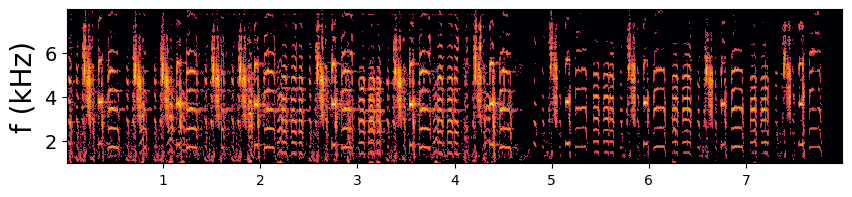

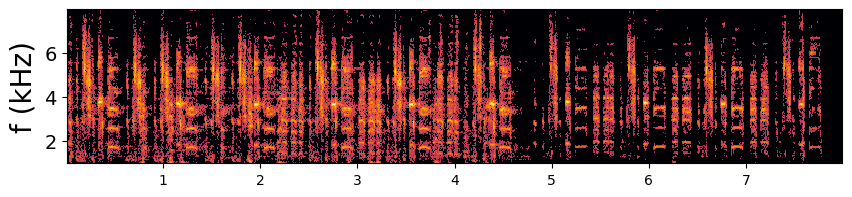

In [ ]:
# MODEL ON CONCATENATED MOTIFS:

model = EncodecModel.encodec_model_48khz()
model.set_target_bandwidth(24.0)

# Concatenate motifs
num_motifs = len(audio_motifs)
y = np.squeeze(audio_motifs.reshape(1, -1))
y = fh.noncausal_filter_1d(y, b1000, a1000)

# Plot concatenated spectrogram
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plot_spectrogram(y, sr, ax)

# Convert to expanded float torch tensor:
wav = arr_to_torch_tensor(y.copy()) #[1xN]

# Compute compressed codes:
encoded_frames, resamp_wav = audio_codes_encodec_fb(wav, sr, model)

# We concatenate the encoded frames to get the continuous encoded representation of the audio, which we will regress from neural data:
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]: B=1, n_q = #codebooks (16 for 24bps), T = encoded TimeSeq

# Decode audio from latents
decoded_audio = model.decode(encoded_frames)
print(decoded_audio.shape, decoded_audio)

# Reconvert decoded audio to original sampling rate
model_sr, target_sr = model.sample_rate, sr 
resamp_decoded_audio = convert_audio(decoded_audio, model_sr, target_sr, target_channels=1) #[2xN] if model 48kHz

# DECODED spectrogram resampled to ORIGINAL sr
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plot_spectrogram(resamp_decoded_audio[0,0].detach().numpy(), sr, ax)

In [ ]:
# Run model ON SEPARATE MOTIFS and create pandas df:
model = EncodecModel.encodec_model_48khz()
model.set_target_bandwidth(24.0)

pd_encodec = pd.DataFrame([], columns = ['code' + str(x) for x in range(16)] + ['motif'] + ['audio_scale'])

for mot in range(len(audio_motifs)):

    # Motif
    y, sr = audio_motifs[mot], sr
    y = fh.noncausal_filter_1d(y, b1000, a1000)

    # Convert to expanded float torch tensor:
    wav = arr_to_torch_tensor(y.copy()) #[1xN]

    # Compute compressed codes:
    encoded_frames, resamp_wav = audio_codes_encodec_fb(wav, sr, model)

    # We concatenate the encoded frames to get the continuous encoded representation of the audio, which we will regress from neural data:
    codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]: B=1, n_q = #codebooks (16 for 24bps), T = encoded TimeSeq

    print(codes.shape)

    # Add to Pandas df
    df = pd.DataFrame(np.squeeze(encoded_frames[0][0]).T, columns = ['code' + str(x) for x in range(codes.shape[1])])
    df['motif'] = mot
    df['audio_scale'] = float(encoded_frames[0][1])
    
    pd_encodec = pd.concat([pd_encodec, df], ignore_index=True)
    
pd_encodec

torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])
torch.Size([1, 16, 120])


code0 code1 code2 code3 code4 code5 code6 code7 code8 code9 code10  \
0      214   976   805   485   475   906    75   988   314   406    201   
1      214   976   925   962   646   399   748    71   533   139    491   
2      118   989   925   448   497   762    53   663   974   991     75   
3      452   989   405  1023   298   522    89   686   292   559    369   
4      717   989   187   682   559   465   666   894   238   948    478   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...    ...   
1195   214   882  1022   485   979  1018   452  1017   957   922    959   
1196   214   882  1022   485   979  1018   973   309   475   982    732   
1197   214   882  1022   485   979  1018   452  1017   635   922    959   
1198   214   882  1022   963   979   399   746   440  1023   982    838   
1199   214   882  1022   485   979  1018   973   309  1023   982    237   

     code11 code12 code13 code14 code15 motif  audio_scale  
0       603   1005    891     69    306     0  2820.458984  
1       934    962    680    304    409     0  2820.458984  
2       652    465    163   1020    479     0  2820.458984  
3       720    754    125    452    725     0  2820.458984  
4      1009    941    711    490    305     0  2820.458984  
...     ...    ...    ...    ...    ...   ...          ...  
1195    493     10   1022    333    268     9  1123.150146  
1196    924   1005    841    275    307     9  1123.150146  
1197    460   1015   1022    333    307     9  1123.150146  
1198    831     10    300    179    483     9  1123.150146  
1199    460    869   1022    415    366     9  1123.150146  

[1200 rows x 18 columns]

In [ ]:
np.unique(pd_encodec['audio_scale'])

array([1123.15014648, 1520.16601562, 1650.99182129, 1710.89501953,
       2257.24536133, 2551.90698242, 2621.55078125, 2748.55151367,
       2756.50756836, 2820.45898438])

## Functions for regression

## Multinomial Logistic Regression (map) from neural_singnal to human_labels

#### Now we have 2 signals:

Neural signal:           of length X \
Encoded audio signal:    of lenght Y

e.g. \
traj_dict['traj_ra_15ms'].shape = [8x33] \
codes.shape                     = [1x16x75]

We aim to regress all 8 factors to each of the 16 codebooks.

Because these signals have different sampling rates, we have 2 options: downsample the encoded audio, or upsample the neural data.
We will try the latter first, since we do not want to lose resolution in the audio domain, which would cause the reconstruction of the song to deteriorate.

In [ ]:
# Excclude one motif for testing
X_train = pd_trajectories[pd_trajectories['motif'] != 9].drop(['motif'], axis=1).to_numpy().T
X_test  = pd_trajectories[pd_trajectories['motif'] == 9].drop(['motif'], axis=1).to_numpy().T

y_train = pd_trajectory_labels[pd_trajectory_labels['motif'] != 9].drop(['motif'], axis=1).to_numpy().T
y_test = pd_trajectory_labels[pd_trajectory_labels['motif'] == 9].drop(['motif'], axis=1).to_numpy().T

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape )

(24, 477) (1, 180000) (24, 53) (1, 20000)


In [ ]:
pd_trajectory_labels

label motif
0         13     0
1         13     0
2         13     0
3         13     0
4         13     0
...      ...   ...
199995    13     9
199996    13     9
199997    13     9
199998    13     9
199999    13     9

[200000 rows x 2 columns]

In [ ]:
X, y = X_train.T, y_train[0,:].astype('int')
print(X.shape, y.shape, type(X), type(y))
print(Counter(y), len(np.unique(y)))

# define the multinomial logistic regression model
mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
# fit the model on the whole training dataset
mlr.fit(X, y)

# predict the class label
yhat = mlr.predict(X_test.T)


plt.plot(y_test.T, linewidth=4)
plt.plot(yhat, linewidth=2)


(477, 24) (180000,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Counter({8: 56954, 5: 29507, 2: 27857, 9: 26839, 4: 13490, 3: 9366, 1: 8229, 13: 6597, 10: 1161}) 9


ValueError: Found input variables with inconsistent numbers of samples: [477, 180000]

(297, 8) (297,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Counter({7: 88, 5: 74, 2: 61, 4: 34, 3: 22, 1: 15, 9: 2, 8: 1}) 8


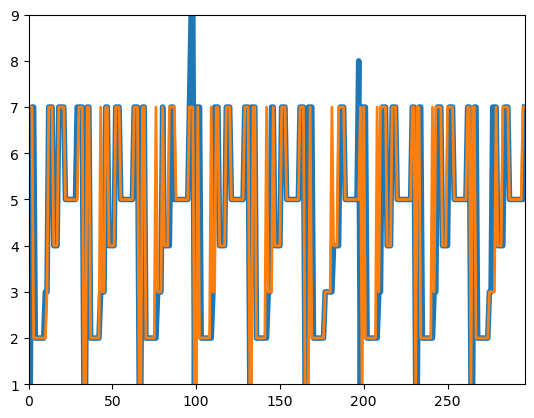

In [ ]:
X, y = X_train.T, y_train[0,:].astype('int')
print(X.shape, y.shape, type(X), type(y))
print(Counter(y), len(np.unique(y)))

# define the multinomial logistic regression model
mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
# fit the model on the whole training dataset
mlr.fit(X, y)

# predict the class label
yhat = mlr.predict(X)

plt.plot(y, linewidth=4)
plt.plot(yhat, linewidth=2)

## Multinomial Logistic Regression (map) from neural_signals to audio_codes

In [ ]:
pd_trajectories

factor0   factor1   factor2   factor3   factor4   factor5   factor6  \
0   -0.225694 -0.322066 -0.178389 -2.189064  1.592851  0.997706 -0.584473   
1    0.105187 -0.241453 -0.058239 -1.595868  0.348767  0.927679  0.151454   
2    0.108050 -0.552638  0.820456 -2.778275  0.883431  0.515279  0.782274   
3   -0.337041 -0.066205  1.616870 -2.810234  0.820280 -0.438853  1.210313   
4    0.521558  0.679336  1.226941 -2.735890  2.191357  0.245410  0.720238   
..        ...       ...       ...       ...       ...       ...       ...   
525 -0.829707  2.104338  0.400404  0.710240 -0.227316  0.346641 -1.465093   
526 -0.826768  2.153395  0.438141  0.769676 -0.241103  0.253295 -1.342994   
527 -0.794365  2.164853  0.482923  0.836006 -0.278468  0.307080 -1.397771   
528 -0.781221  2.065768  0.391596  0.704361  0.015110  0.280682 -1.475113   
529 -0.700506  2.072368  0.486271  0.622152 -0.163333  0.396043 -1.172464   

      factor7   factor8   factor9  ...  factor15  factor16  factor17  \
0    0.390201  1.003446 -0.438912  ... -0.117760 -0.409952 -0.274712   
1    0.027286  0.207072 -0.861818  ... -0.204392 -1.418213 -0.900364   
2    1.400877  1.028719 -0.429253  ... -1.076696 -0.452261 -0.957317   
3    1.255711  1.553090  0.503322  ... -0.877343 -0.040456 -0.566335   
4    0.196457  1.527445 -0.557674  ...  0.201064  0.451110 -0.247452   
..        ...       ...       ...  ...       ...       ...       ...   
525 -0.042950 -0.263852  0.664515  ...  0.070155  0.193766 -0.802988   
526 -0.076588 -0.084057  0.694815  ...  0.251479  0.336929 -0.725672   
527 -0.136310 -0.051923  0.625219  ...  0.321091  0.139672 -0.713060   
528 -0.249881 -0.139470  0.637148  ...  0.149650  0.084147 -0.791982   
529 -0.307572 -0.302493  0.398814  ...  0.006765  0.308843 -0.880819   

     factor18  factor19  factor20  factor21  factor22  factor23  motif  
0    0.175307  0.224613 -0.563522  0.462599 -0.076564  0.002721      0  
1   -0.765280  0.019936 -0.500657  0.339349 -0.160579 -0.046186      0  
2   -0.507183 -0.117902 -0.371042  0.326508 -0.122970 -0.072498      0  
3   -0.116919  0.062808  0.087434 -0.021398 -0.224169 -0.265062      0  
4    0.217232  0.196478  0.333521 -0.238941 -0.227385 -0.384570      0  
..        ...       ...       ...       ...       ...       ...    ...  
525  0.257989 -0.111418  0.956580  0.468871  0.010749  0.286381      9  
526  0.310525 -0.161828  0.969840  0.488429  0.027538  0.281755      9  
527  0.260484 -0.129510  1.006286  0.471392  0.018032  0.261032      9  
528  0.161002 -0.045349  1.079244  0.414666 -0.027033  0.235356      9  
529  0.151911 -0.115448  1.038902  0.387811 -0.057615  0.231430      9  

[530 rows x 25 columns]

In [ ]:
pd_encodec

code0 code1 code2 code3 code4 code5 code6 code7 code8 code9 code10  \
0      214   976   805   485   475   906    75   988   314   406    201   
1      214   976   925   962   646   399   748    71   533   139    491   
2      118   989   925   448   497   762    53   663   974   991     75   
3      452   989   405  1023   298   522    89   686   292   559    369   
4      717   989   187   682   559   465   666   894   238   948    478   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...    ...   
1195   214   882  1022   485   979  1018   452  1017   957   922    959   
1196   214   882  1022   485   979  1018   973   309   475   982    732   
1197   214   882  1022   485   979  1018   452  1017   635   922    959   
1198   214   882  1022   963   979   399   746   440  1023   982    838   
1199   214   882  1022   485   979  1018   973   309  1023   982    237   

     code11 code12 code13 code14 code15 motif  audio_scale  
0       603   1005    891     69    306     0  2820.458984  
1       934    962    680    304    409     0  2820.458984  
2       652    465    163   1020    479     0  2820.458984  
3       720    754    125    452    725     0  2820.458984  
4      1009    941    711    490    305     0  2820.458984  
...     ...    ...    ...    ...    ...   ...          ...  
1195    493     10   1022    333    268     9  1123.150146  
1196    924   1005    841    275    307     9  1123.150146  
1197    460   1015   1022    333    307     9  1123.150146  
1198    831     10    300    179    483     9  1123.150146  
1199    460    869   1022    415    366     9  1123.150146  

[1200 rows x 18 columns]

#### Now we have 3 pandas dataframes:

Neural signals (trajectories):   of length X \
Labeled behavior:                of length X \
Encoded audio signal:            of lenght Y

e.g.
    
pd_trajectories.shape = [330 x factors(8)] \
pd_trajectory_labels  = [330 x 1] \
pd_encodec.shape      = [750 x codes(16)]

We aim to regress all 8 factors to each of the 16 codebooks / 1 label.

Because these signals have different sampling rates, we have 2 options: downsample the encoded audio, or upsample the neural data.
We will do the latter, since we do not want to lose resolution in the audio domain, which would cause the reconstruction of the spectrogram to deteriorate.

We will train on 9 motifs and test on a single one.

In [ ]:
# Excclude one motif for testing
X_train = pd_trajectories[pd_trajectories['motif'] != 9].drop(['motif'], axis=1).to_numpy().T
X_test  = pd_trajectories[pd_trajectories['motif'] == 9].drop(['motif'], axis=1).to_numpy().T

y_train = pd_encodec[pd_encodec['motif'] != 9].drop(['motif', 'audio_scale'], axis=1).to_numpy().T
y_test = pd_encodec[pd_encodec['motif'] == 9].drop(['motif', 'audio_scale'], axis=1).to_numpy().T

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24, 477), (16, 1080), (24, 53), (16, 120))

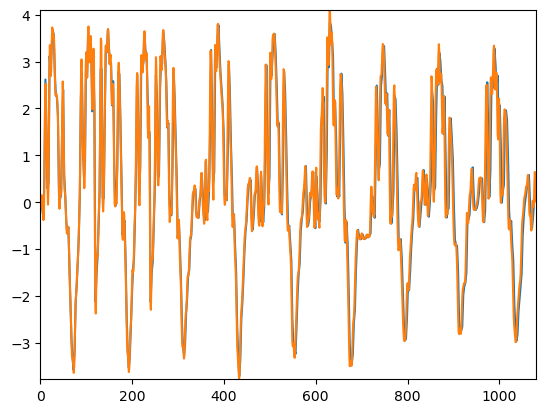

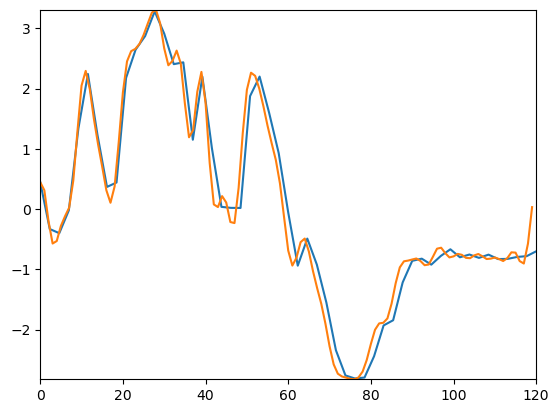

In [ ]:
from scipy.signal import resample
from scipy.signal import resample_poly

# Resample 2D array (TRAIN)
resamp_X_train = resample(X_train, y_train.shape[1], axis=1)
plt.figure()
plt.plot(np.linspace(0, resamp_X_train.shape[1], num=len(X_train[0,:])), X_train[0,:])
plt.plot(resamp_X_train[0,:])

# Resample 2D array (TEST)
resamp_X_test = resample(X_test, y_test.shape[1], axis=1)
plt.figure()
plt.plot(np.linspace(0, resamp_X_test.shape[1], num=len(X_test[0,:])), X_test[0,:])
plt.plot(resamp_X_test[0,:])

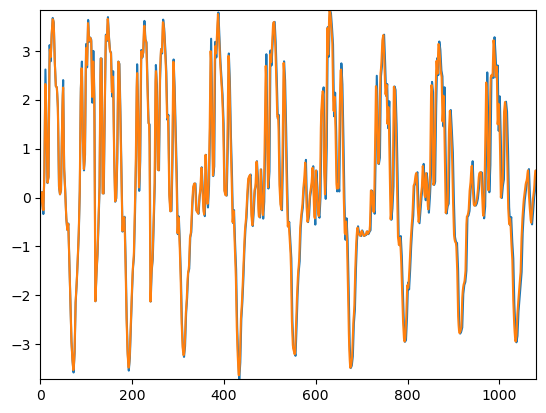

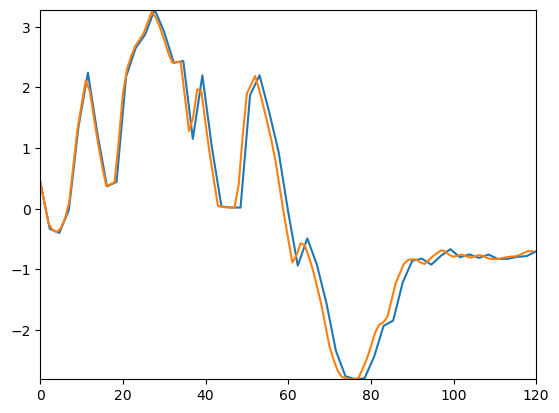

In [ ]:
# Resample 2D array (TRAIN)
resample_factor = y_train.shape[1]/X_train.shape[1]
input_fs, output_fs = X_train.shape[1], X_train.shape[1]*resample_factor
resamp_X_train = resample_by_interpolation_2d(X_train, input_fs, output_fs)

plt.figure()
plt.plot(np.linspace(0, int(output_fs), int(input_fs)), X_train[0,:])
plt.plot(resamp_X_train[0,:])

# Resample 2D array (TEST)
resample_factor = y_test.shape[1]/X_test.shape[1]
input_fs, output_fs = X_test.shape[1], X_test.shape[1]*resample_factor
resamp_X_test = resample_by_interpolation_2d(X_test, input_fs, output_fs)

plt.figure()
plt.plot(np.linspace(0, int(output_fs), int(input_fs)), X_test[0,:])
plt.plot(resamp_X_test[0,:])

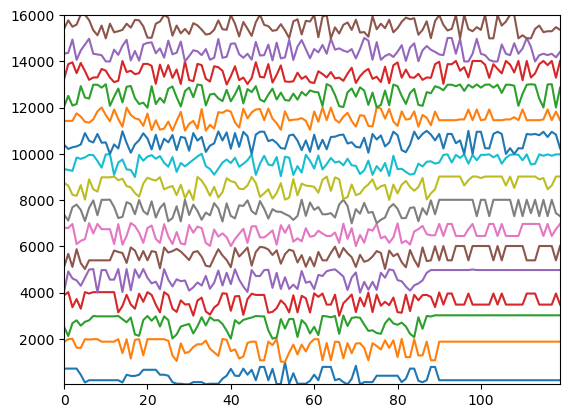

In [ ]:
# Plot each of the 16 codecs from Encodec'd audio
plt.figure()

for codec in range(y_test.shape[0]):
    plt.plot(y_test[codec] + codec*1000)

### Predict single code

In [ ]:
resamp_X_train.shape

(24, 1080)

(1080, 24) (1080,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Counter({214: 147, 452: 140, 132: 131, 717: 91, 39: 83, 790: 76, 118: 74, 63: 61, 273: 42, 409: 42, 989: 42, 401: 28, 278: 23, 666: 21, 189: 17, 127: 14, 595: 8, 837: 6, 174: 5, 698: 4, 707: 4, 727: 3, 551: 3, 62: 2, 972: 2, 255: 1, 560: 1, 697: 1, 167: 1, 327: 1, 712: 1, 572: 1, 940: 1, 196: 1, 642: 1, 442: 1}) 36


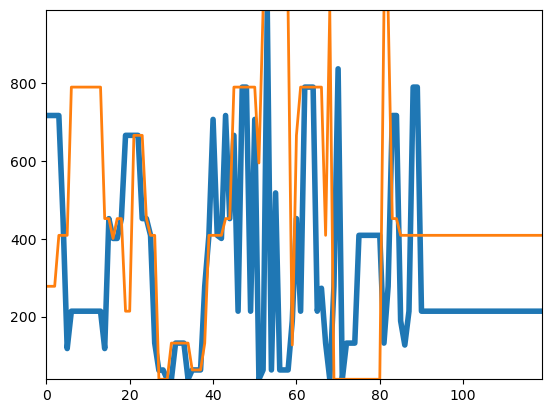

In [ ]:
X, y = resamp_X_train.T, y_train[0,:].astype('int')
print(X.shape, y.shape, type(X), type(y))
print(Counter(y), len(np.unique(y)))

# define the multinomial logistic regression model
mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
# fit the model on the whole training dataset
mlr.fit(X, y)

# predict the class label
yhat = mlr.predict(resamp_X_test.T)


plt.plot(y_test[0,:], linewidth=4)
plt.plot(yhat, linewidth=2)

### Predict all codes for single motif

In [ ]:
resamp_X_train.shape, y_train.shape, y_test.shape

((24, 1080), (16, 1080), (16, 120))

In [ ]:
y_train

array([[214, 214, 118, ..., 132, 132, 132],
       [976, 976, 989, ..., 404, 404, 404],
       [805, 925, 925, ..., 200, 235, 547],
       ...,
       [891, 680, 163, ..., 423, 487, 956],
       [69, 304, 1020, ..., 824, 1011, 1],
       [306, 409, 479, ..., 565, 1003, 408]], dtype=object)

In [ ]:
codes = []

for c in range(y_test.shape[0]):
    X, y = resamp_X_train.T, y_train[c,:].astype('int')
    
    # define the multinomial logistic regression model
    mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
    # fit the model on the whole training dataset
    mlr.fit(X, y)

    # predict the code type
    codes.append(mlr.predict(resamp_X_test.T))


In [ ]:
decoded_audio.shape

torch.Size([1, 2, 384000])

In [ ]:
model.decode(codes)

ValueError: too many values to unpack (expected 2)

/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)
/tmp/ipykernel_2949560/1766771654.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_yticklabels(['1', '2', '4', '6', '8'], fontsize=14)


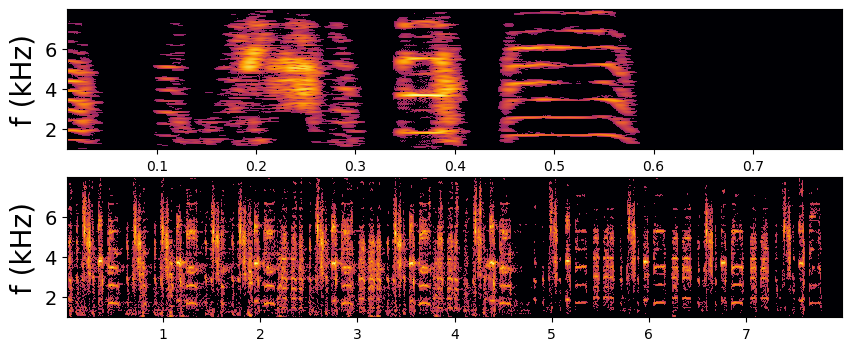

In [ ]:
# Reconvert decoded audio to original sampling rate
model_sr, target_sr = model.sample_rate, sr 
resamp_decoded_audio = convert_audio(decoded_audio.float(), model_sr, target_sr, target_channels=1) # [2xN] if model 48kHz

# DECODED spectrogram resampled to ORIGINAL sr
fig, ax = plt.subplots(2, 1, figsize=(10, 4))

# Motif
y, sr = audio_motifs[9], sr
y = fh.noncausal_filter_1d(y, b1000, a1000)
plot_spectrogram(y, sr, ax[0])

plot_spectrogram(resamp_decoded_audio[0,0].detach().numpy(), sr, ax[1])

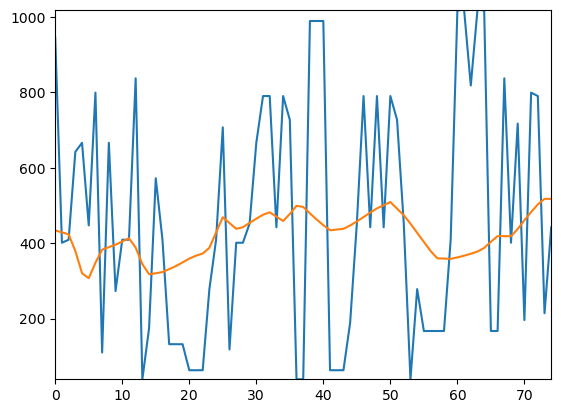

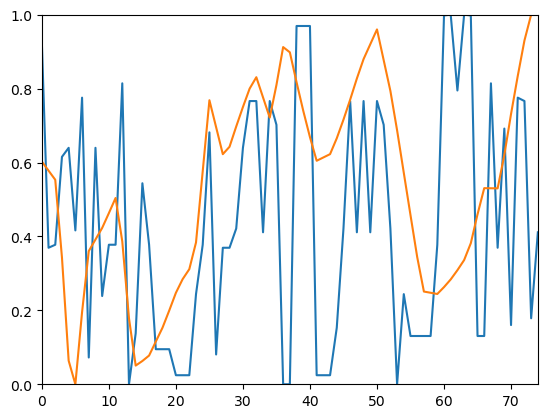

In [ ]:
y_p = regr.predict(resamp_X_test.T)

plt.figure()
plt.plot(y_test[0,:])
plt.plot(y_p)

plt.figure()
plt.plot(normalize_signal(y_test[0,:]))
plt.plot(normalize_signal(y_p))

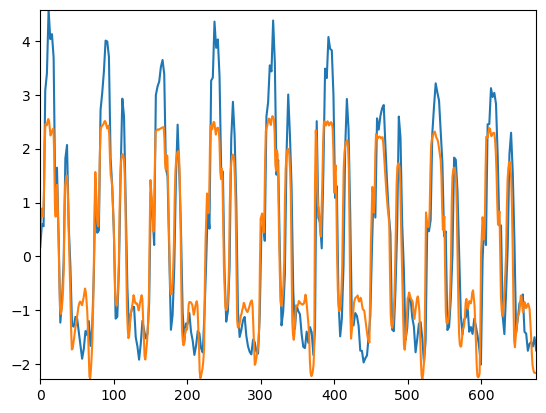

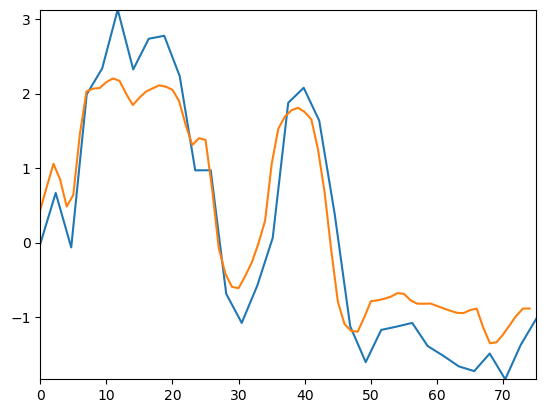

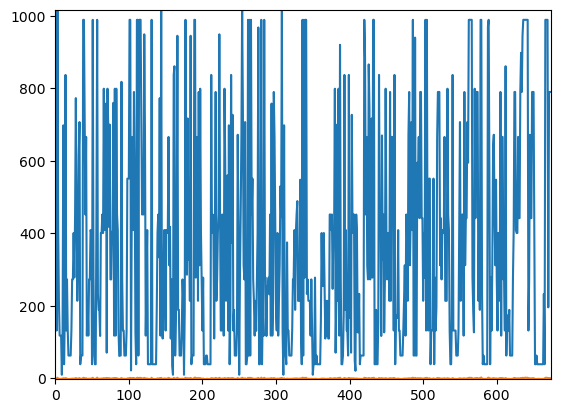

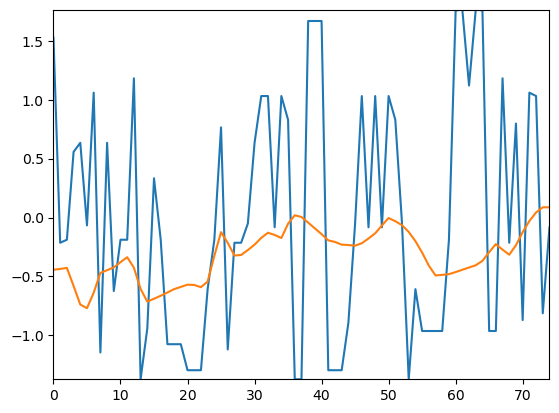

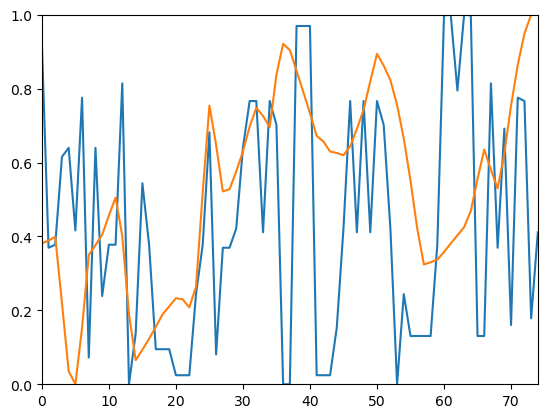

In [ ]:
"""
Decode all 16 codes from latent states and reconstruct spectrogram.
"""

X_train.shape, y_train.shape, X_test.shape, y_train.shape


# Normalize and resample.

# Resample 2D array (TRAIN)
resample_factor = y_train.shape[1]/X_train.shape[1]
input_fs, output_fs = X_train.shape[1], X_train.shape[1]*resample_factor
resamp_X_train = resample_by_interpolation_2d(X_train, input_fs, output_fs)
res_norm_X_train = stats.zscore(resamp_X_train, axis=0)

plt.figure()
plt.plot(np.linspace(0, int(output_fs), int(input_fs)), X_train[0,:])
plt.plot(res_norm_X_train[0,:])

# Resample 2D array (TEST)
resample_factor = y_test.shape[1]/X_test.shape[1]
input_fs, output_fs = X_test.shape[1], X_test.shape[1]*resample_factor
resamp_X_test = resample_by_interpolation_2d(X_test, input_fs, output_fs)
res_norm_X_test = stats.zscore(resamp_X_test, axis=0)

# Z-score Targets
norm_y_train = stats.zscore(y_train.astype(float), axis=0)
norm_y_test = stats.zscore(y_test.astype(float), axis=0)

# Fit
X, y = res_norm_X_train, norm_y_train[0,:]

regr = LinearRegression()
regr.fit(res_norm_X_train.transpose(), y)
regr.score(res_norm_X_train.T, y), regr.coef_, regr.intercept_


plt.figure()
plt.plot(np.linspace(0, int(output_fs), int(input_fs)), X_test[0,:])
plt.plot(res_norm_X_test[0,:])

plt.figure()
plt.plot(y_train[0,:])
plt.plot(y)

y_p = regr.predict(res_norm_X_test.T)

plt.figure()
plt.plot(stats.zscore(y_test[0,:].astype(float)))
plt.plot(y_p)

plt.figure()
plt.plot(normalize_signal(y_test[0,:]))
plt.plot(normalize_signal(y_p))


In [ ]:
"""
Decode all 16 codes from latent states and reconstruct spectrogram.
"""

X_train.shape, y_train.shape, X_test.shape, y_train.shape


# Normalize and resample.

# Resample 2D array (TRAIN)
resample_factor = y_train.shape[1]/X_train.shape[1]
input_fs, output_fs = X_train.shape[1], X_train.shape[1]*resample_factor
resamp_X_train = resample_by_interpolation_2d(X_train, input_fs, output_fs)

# Resample 2D array (TEST)
resample_factor = y_test.shape[1]/X_test.shape[1]
input_fs, output_fs = X_test.shape[1], X_test.shape[1]*resample_factor
resamp_X_test = resample_by_interpolation_2d(X_test, input_fs, output_fs)

# Z-score Features and Targets
res_norm_X_train = stats.zscore(resamp_X_train, axis=0)
res_norm_X_test = stats.zscore(resamp_X_test, axis=0)
norm_y_train = stats.zscore(y_train.astype(float), axis=0)
norm_y_test = stats.zscore(y_test.astype(float), axis=0)

In [ ]:
res_norm_X_train.shape, norm_y_train.shape, res_norm_X_test.shape, norm_y_test.shape

((8, 675), (16, 675), (8, 75), (16, 75))

In [ ]:
encoded_frames

[(tensor([[[ 945,  401,  409,  ...,  790,  214,  442],
           [ 817,  989,  611,  ...,  360,  826,   77],
           [ 680,  925,  902,  ...,  993,  993,  993],
           ...,
           [1012,  479,  686,  ...,  855,  306,  909],
           [ 491,  394,  320,  ...,  647,  947,  333],
           [ 521,  624,   11,  ...,  773,   47,  253]]]),
  tensor([[1499.5023]]))]

In [ ]:
y_test.shape

(16, 75)

ValueError: too many values to unpack (expected 2)

In [ ]:
y_test.shape

(16, 75)

In [ ]:
predicted_codes = np.zeros(y_test.shape)
predicted_codes.shape

(16, 75)

In [ ]:
def multiple_targets_MLR(X_train, y_train, X_test, y_test):
    
    predicted_codes = np.zeros(y_test.shape)
    
    for target in range(len(y_train)):
        
        # Fit MLR model
        X, y = X_train, y_train[target]
        
        regr = LinearRegression()
        regr.fit(X.transpose(), y)
        score_train = regr.score(X.T, y) #regr.coef_, regr.intercept_
        
        # Predict
        y_p = regr.predict(X_test.T)
        predicted_codes[target] = y_p
        
        score_test = regr.score(X_test.T, y_test[target]) #regr.coef_, regr.intercept_            
        print(score_train, score_test)
        
    return predicted_codes
    

In [ ]:
pc = multiple_targets_MLR(resamp_X_train, y_train, resamp_X_test, y_test)

0.07870627244720574 0.00927500423341543
0.028330207324198553 -0.00856034227762037
0.03337882173351303 0.000905752425781392
0.01798876064658894 -0.10200844370545625
0.020578810873964737 -0.17461825063914405
0.010424969641768866 -0.03149649545203714
0.027505119588035698 -0.09532791432681487
0.015751695813303934 0.009689919225650212
0.02365938234348508 -0.07192410307112929
0.017799456625358978 0.022820988672593634
0.013727084447387794 -0.015121011054175515
0.026182291609254227 -0.06510078496496985
0.011942009546270338 -0.0507460723823685
0.016374136400937656 -0.08233754073380206
0.007602838241080767 -0.07879821608559778
0.012627623334977023 -0.12802873155624117


In [ ]:
# DECODED spectrogram resampled to ORIGINAL sr
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plot_spectrogram(resamp_decoded_audio[0,0].detach().numpy(), sr, ax)

In [ ]:
dec_test[0][0][0]

tensor([[ 945,  401,  409,  ...,  790,  214,  442],
        [ 817,  989,  611,  ...,  360,  826,   77],
        [ 680,  925,  902,  ...,  993,  993,  993],
        ...,
        [1012,  479,  686,  ...,  855,  306,  909],
        [ 491,  394,  320,  ...,  647,  947,  333],
        [ 521,  624,   11,  ...,  773,   47,  253]])

In [ ]:
# Decode audio from latents
# decoded_audio = model.decode(encoded_frames)

dec_test = encoded_frames
dec_test[0][0][0] = torch.Tensor(pc)

decoded_audio = model.decode(dec_test)

In [ ]:
encoded_frames

[(tensor([[[ 945,  401,  409,  ...,  790,  214,  442],
           [ 817,  989,  611,  ...,  360,  826,   77],
           [ 680,  925,  902,  ...,  993,  993,  993],
           ...,
           [1012,  479,  686,  ...,  855,  306,  909],
           [ 491,  394,  320,  ...,  647,  947,  333],
           [ 521,  624,   11,  ...,  773,   47,  253]]]),
  tensor([[1499.5023]]))]

In [ ]:
dec_test[0][0][0][0]

tensor([ 945,  401,  409,  642,  666,  447,  799,  110,  666,  273,  409,  409,
         837,   39,  174,  572,  409,  132,  132,  132,   63,   63,   63,  278,
         409,  707,  118,  401,  401,  452,  666,  790,  790,  442,  790,  727,
          39,   39,  989,  989,  989,   63,   63,   63,  189,  452,  790,  442,
         790,  442,  790,  727,  452,   39,  278,  167,  167,  167,  167,  409,
        1017, 1019,  818, 1019, 1017,  167,  167,  837,  401,  717,  196,  799,
         790,  214,  442])

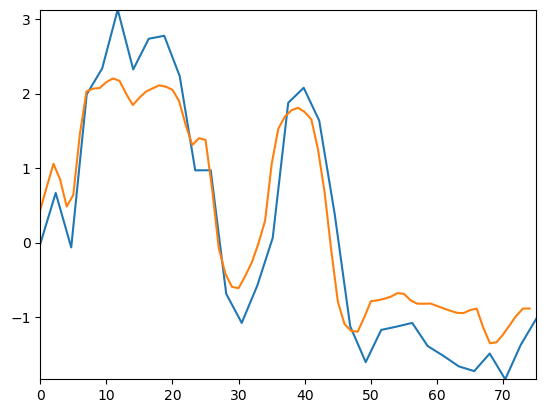

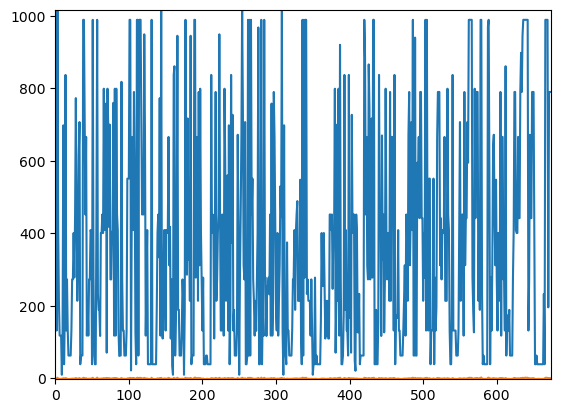

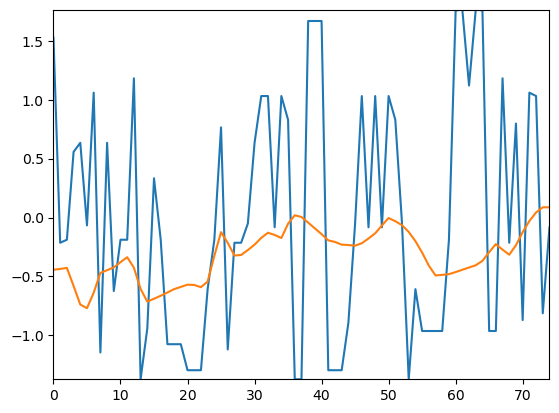

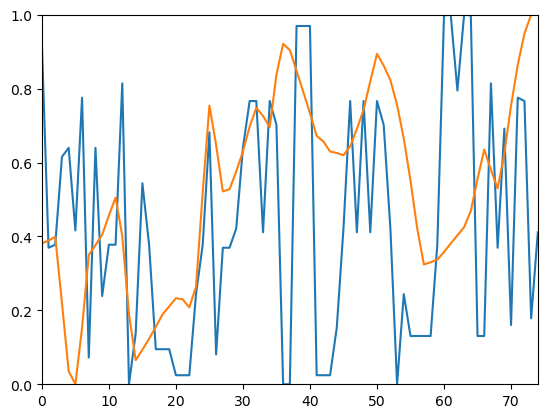

In [ ]:



# Fit
X, y = res_norm_X_train, norm_y_train[0,:]

regr = LinearRegression()
regr.fit(res_norm_X_train.transpose(), y)
regr.score(res_norm_X_train.T, y), regr.coef_, regr.intercept_


plt.figure()
plt.plot(np.linspace(0, int(output_fs), int(input_fs)), X_test[0,:])
plt.plot(res_norm_X_test[0,:])

plt.figure()
plt.plot(y_train[0,:])
plt.plot(y)

y_p = regr.predict(res_norm_X_test.T)

plt.figure()
plt.plot(stats.zscore(y_test[0,:].astype(float)))
plt.plot(y_p)

plt.figure()
plt.plot(normalize_signal(y_test[0,:]))
plt.plot(normalize_signal(y_p))


#### Now we have 2 signals:

Neural signal:           of length X \
Encoded audio signal:    of lenght Y

e.g. \
traj_dict['traj_ra_15ms'].shape = [8x33] \
codes.shape                     = [1x16x75]

We aim to regress all 8 factors to each of the 16 codebooks.

Because these signals have different sampling rates, we have 2 options: downsample the encoded audio, or upsample the neural data.
We will try the latter first, since we do not want to lose resolution in the audio domain, which would cause the reconstruction of the song to deteriorate.

In [ ]:
traj_dict['traj_ra_15ms'].shape, codes.shape, traj_dict['traj_labels'].shape

((10, 8, 33), torch.Size([1, 16, 75]), (10, 33))

(8, 33) torch.Size([16, 75])
2.272727272727273
(8, 75) torch.Size([16, 75])


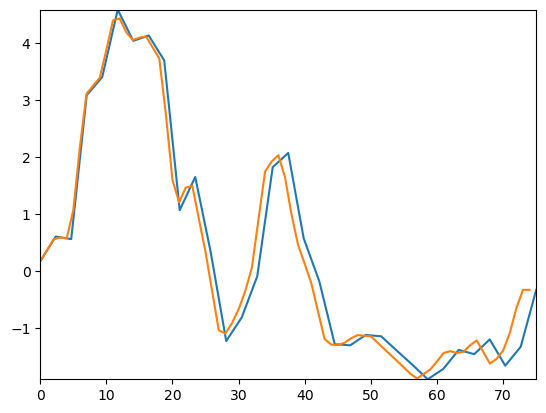

In [ ]:
neural_signal  = traj_dict['traj_ra_15ms'][motif,:,:]
encodec_signal = codes[0,:,:]

print(neural_signal.shape, encodec_signal.shape)

resample_factor = encodec_signal.shape[1]/neural_signal.shape[1]

print(resample_factor)

# Resample 2D array
input_fs, output_fs = neural_signal.shape[1], neural_signal.shape[1]*resample_factor
resamp_neural_signal = resample_by_interpolation_2d(neural_signal, input_fs, output_fs)

print(resamp_neural_signal.shape, encodec_signal.shape)

plt.plot(np.linspace(0, int(output_fs), int(input_fs)), neural_signal[0,:])
plt.plot(resamp_neural_signal[0,:])

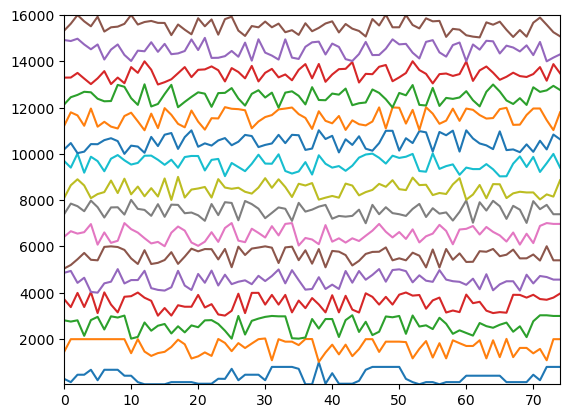

In [ ]:
# Plot each of the 16 codecs from Encodec'd audio
plt.figure()

for codec in range(encodec_signal.shape[0]):
    plt.plot(encodec_signal[codec] + codec*1000)

In [ ]:
traj_dict['traj_labels'].shape

(10, 33)

In [ ]:
neural_signal.shape, X.shape

((8, 33), (33, 8))

In [ ]:
traj_dict['traj_labels'][0,:]

array([1, 1, 7, 7, 2, 2, 2, 2, 2, 2, 3, 3, 7, 7, 7, 4, 4, 4, 7, 7, 7, 7,
       5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7])

In [ ]:
y.shape

(675,)

(33, 8) (33,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Counter({7: 13, 5: 7, 2: 6, 4: 3, 1: 2, 3: 2}) 6


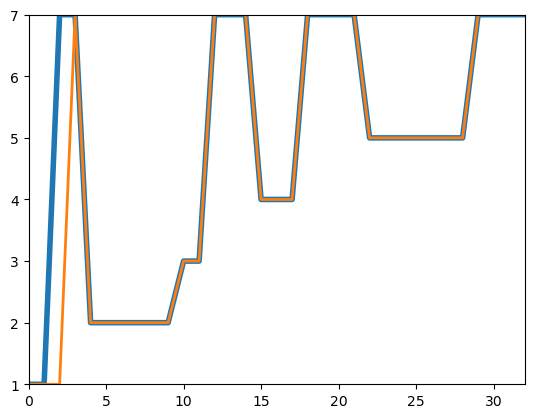

In [ ]:
X, y = neural_signal.T, traj_dict['traj_labels'][0,:].astype('int')
print(X.shape, y.shape, type(X), type(y))
print(Counter(y), len(np.unique(y)))

# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
# fit the model on the whole training dataset
model.fit(X, y)

# predict the class label
yhat = model.predict(X)

plt.plot(y, linewidth=4)
plt.plot(yhat, linewidth=2)

In [ ]:
colors = {1:'#000000', # s1
          2:'#B67FED', # s2
          3:'#C06E1B', # s3
          4:'#128080', # s4
          5:'#804912', # s5
          6:'#286DB6', # s6
          7:'#D3D3D3', # s7
          8:'#D3D3D3', # motif_silence
          9:'#349946', # intra-motif note: green #349946
          10:'#FEB4D9', # intro note
          11:'#FFFF6D', # calls
          12:'#00FFFF', # Unlabeled
          13:'#EBEBEB', # silence
          14:'#EBEBEB'} 

In [ ]:
# PARAMS

# smoothing params
interpolation_multiplier = 10
interpolation_order = 5

### Create pandas dataframe

In [ ]:
lfads_dir = '/net2/sandbox/gdynsys/birdsong/outputs/'

lfads_files = []
for root, dirs, files in os.walk(lfads_dir, topdown=False):
    # print(root, dirs, files)
    for name in files:
        lfads_files.append(name)
        
lfads_files = sorted(lfads_files)
display(lfads_files)

['evalfactors_lfads-pt-hvc-ctrl-b8.pkl',
 'evalfactors_lfads-pt-hvc-ctrl-cfg3.pkl',
 'evalfactors_lfads-pt-hvc-ctrl.pkl',
 'evalfactors_lfads-pt-hvc-noctrl.pkl',
 'evalfactors_lfads-pt-ra-ctrl-b8.pkl',
 'evalfactors_lfads-pt-ra-ctrl-cfg3.pkl',
 'evalfactors_lfads-pt-ra-ctrl.pkl',
 'evalfactors_pt-r12r13-hvc-1.pkl',
 'evalfactors_pt-r12r13-hvc-2.pkl',
 'evalfactors_pt-r12r13-hvc-3.pkl',
 'evalfactors_pt-r12r13-hvc-nc.pkl',
 'evalfactors_pt-r12r13-ra-1.pkl',
 'evalfactors_pt-r12r13-ra-2.pkl',
 'evalfactors_pt-w12m7-extcon.pkl',
 'evalfactors_pt-w12m7-hvc-1.pkl',
 'evalfactors_pt-w12m7-hvc-2.pkl',
 'evalfactors_pt-w12m7-hvc-3.pkl',
 'evalfactors_pt-w12m7-hvc-4.pkl',
 'evalfactors_pt-w12m7-hvc-nc.pkl',
 'evalfactors_pt-w12m7-hvc-nc2.pkl',
 'evalfactors_pt-w12m7-hvc-nc3.pkl',
 'evalfactors_pt-w12m7-hvc-nc4.pkl',
 'evalfactors_pt-w12m7-ra-1.pkl',
 'evalfactors_pt-y19o20-ra-1.pkl',
 'evalrates_lfads-pt-hvc-ctrl-b8.pkl',
 'evalrates_lfads-pt-hvc-ctrl-cfg3.pkl',
 'evalrates_lfads-pt-hvc-ctrl.pk

In [ ]:
# CREATE DICTS for PD

# Files conraining LFADS trajectories
lfads_results = {
 'evalfactors_lfads-pt-hvc-ctrl-b8.pkl':   'A',
 'evalfactors_lfads-pt-hvc-ctrl-cfg3.pkl': 'A',
 'evalfactors_lfads-pt-hvc-ctrl.pkl':      'A',
 'evalfactors_lfads-pt-hvc-noctrl.pkl':    'A',
 'evalfactors_lfads-pt-ra-ctrl-b8.pkl':    'A',
 'evalfactors_lfads-pt-ra-ctrl-cfg3.pkl':  'A',
 'evalfactors_lfads-pt-ra-ctrl.pkl':       'A',
 'evalfactors_pt-r12r13-hvc-1.pkl':        'B',
 'evalfactors_pt-r12r13-hvc-2.pkl':        'B',
 'evalfactors_pt-r12r13-hvc-3.pkl':        'B',
 'evalfactors_pt-r12r13-hvc-nc.pkl':       'B',
 'evalfactors_pt-r12r13-ra-1.pkl':         'B',
 'evalfactors_pt-r12r13-ra-2.pkl':         'B',
 'evalfactors_pt-w12m7-extcon.pkl':        'A',
 'evalfactors_pt-w12m7-hvc-1.pkl':         'A',
 'evalfactors_pt-w12m7-hvc-2.pkl':         'A',
 'evalfactors_pt-w12m7-hvc-3.pkl':         'A',
 'evalfactors_pt-w12m7-hvc-4.pkl':         'A',
 'evalfactors_pt-w12m7-hvc-nc.pkl':        'A',
 'evalfactors_pt-w12m7-hvc-nc2.pkl':       'A',
 'evalfactors_pt-w12m7-hvc-nc3.pkl':       'A',
 'evalfactors_pt-w12m7-hvc-nc4.pkl':       'A',
 'evalfactors_pt-w12m7-ra-1.pkl':          'A',
 'evalfactors_pt-y19o20-ra-1.pkl':         'C'
}

# Directory of LFADS runs
lfads_dirs = [lfads_dir]*len(lfads_results)

# HVC vs. RA
nucleus = {
 'evalfactors_lfads-pt-hvc-ctrl-b8.pkl':   'HVC',
 'evalfactors_lfads-pt-hvc-ctrl-cfg3.pkl': 'HVC',
 'evalfactors_lfads-pt-hvc-ctrl.pkl':      'HVC',
 'evalfactors_lfads-pt-hvc-noctrl.pkl':    'HVC',
 'evalfactors_lfads-pt-ra-ctrl-b8.pkl':    'RA',
 'evalfactors_lfads-pt-ra-ctrl-cfg3.pkl':  'RA',
 'evalfactors_lfads-pt-ra-ctrl.pkl':       'RA',
 'evalfactors_pt-r12r13-hvc-1.pkl':        'HVC',
 'evalfactors_pt-r12r13-hvc-2.pkl':        'HVC',
 'evalfactors_pt-r12r13-hvc-3.pkl':        'HVCpn',
 'evalfactors_pt-r12r13-hvc-nc.pkl':       'HVC',
 'evalfactors_pt-r12r13-ra-1.pkl':         'RA',
 'evalfactors_pt-r12r13-ra-2.pkl':         'RA',
 'evalfactors_pt-w12m7-extcon.pkl':        'RA',
 'evalfactors_pt-w12m7-hvc-1.pkl':         'HVC',
 'evalfactors_pt-w12m7-hvc-2.pkl':         'HVC',
 'evalfactors_pt-w12m7-hvc-3.pkl':         'HVC',
 'evalfactors_pt-w12m7-hvc-4.pkl':         'HVCpn',
 'evalfactors_pt-w12m7-hvc-nc.pkl':        'HVCpn',
 'evalfactors_pt-w12m7-hvc-nc2.pkl':       'HVCpn',
 'evalfactors_pt-w12m7-hvc-nc3.pkl':       'HVC',
 'evalfactors_pt-w12m7-hvc-nc4.pkl':       'HVC',
 'evalfactors_pt-w12m7-ra-1.pkl':          'RA',
 'evalfactors_pt-y19o20-ra-1.pkl':         'RA'
}

# Corresponding bird / nucleus to each lfads file
lfads_files = list(lfads_results.keys())
bird_name = list(lfads_results.values())
bird_nucleus = list(nucleus.values())

# Trajectory labels for each lfads file
labels_dir = '/net2/expData/speech_bci/lfads_data/LFADS-pickle-files/'
label_files = {
    'A': labels_dir + 'z_w12m7_20_2020-11-04_15ms_labels_docker.pkl',
    'B': labels_dir + 'z_r12r13_21_2021-06-27_15ms_labels_docker.pkl',
    'C': labels_dir + 'z_y19o20_21_2021-10-27_15ms_labels_docker.pkl',
}
trajectory_labels = []
for b in bird_name:
    trajectory_labels.append(label_files[b])
    
# Motif length
motif_lengths = {
    'A': 0.47,
    'B': 0.65,
    'C': 0.45,
}
mot_len = []
for b in bird_name:
    mot_len.append(motif_lengths[b])

# Bin width of each lfads' file trajectories
bin_widths = [15]*len(lfads_files)

In [ ]:
len(bird_name), len(lfads_dirs), len(lfads_files), len(bird_nucleus), len(trajectory_labels), len(mot_len), len(bin_widths)

(24, 24, 24, 24, 24, 24, 24)

In [ ]:
# Create LFADS pandas dataframe

lfads_dict = {
    'bird':               bird_name,
    'lfads_dir':          lfads_dirs,
    'lfads_run':          lfads_files,
    'nucleus':            bird_nucleus,
    'trajectory_labels':  trajectory_labels,
    'mot_len':            mot_len,
    'bin_w':              bin_widths
}
lfads_df = pd.DataFrame.from_dict(lfads_dict)

lfads_df

bird                                lfads_dir  \
0     A  /net2/sandbox/gdynsys/birdsong/outputs/   
1     A  /net2/sandbox/gdynsys/birdsong/outputs/   
2     A  /net2/sandbox/gdynsys/birdsong/outputs/   
3     A  /net2/sandbox/gdynsys/birdsong/outputs/   
4     A  /net2/sandbox/gdynsys/birdsong/outputs/   
5     A  /net2/sandbox/gdynsys/birdsong/outputs/   
6     A  /net2/sandbox/gdynsys/birdsong/outputs/   
7     B  /net2/sandbox/gdynsys/birdsong/outputs/   
8     B  /net2/sandbox/gdynsys/birdsong/outputs/   
9     B  /net2/sandbox/gdynsys/birdsong/outputs/   
10    B  /net2/sandbox/gdynsys/birdsong/outputs/   
11    B  /net2/sandbox/gdynsys/birdsong/outputs/   
12    B  /net2/sandbox/gdynsys/birdsong/outputs/   
13    A  /net2/sandbox/gdynsys/birdsong/outputs/   
14    A  /net2/sandbox/gdynsys/birdsong/outputs/   
15    A  /net2/sandbox/gdynsys/birdsong/outputs/   
16    A  /net2/sandbox/gdynsys/birdsong/outputs/   
17    A  /net2/sandbox/gdynsys/birdsong/outputs/   
18    A  /net2/sandbox/gdynsys/birdsong/outputs/   
19    A  /net2/sandbox/gdynsys/birdsong/outputs/   
20    A  /net2/sandbox/gdynsys/birdsong/outputs/   
21    A  /net2/sandbox/gdynsys/birdsong/outputs/   
22    A  /net2/sandbox/gdynsys/birdsong/outputs/   
23    C  /net2/sandbox/gdynsys/birdsong/outputs/   

                                 lfads_run nucleus  \
0     evalfactors_lfads-pt-hvc-ctrl-b8.pkl     HVC   
1   evalfactors_lfads-pt-hvc-ctrl-cfg3.pkl     HVC   
2        evalfactors_lfads-pt-hvc-ctrl.pkl     HVC   
3      evalfactors_lfads-pt-hvc-noctrl.pkl     HVC   
4      evalfactors_lfads-pt-ra-ctrl-b8.pkl      RA   
5    evalfactors_lfads-pt-ra-ctrl-cfg3.pkl      RA   
6         evalfactors_lfads-pt-ra-ctrl.pkl      RA   
7          evalfactors_pt-r12r13-hvc-1.pkl     HVC   
8          evalfactors_pt-r12r13-hvc-2.pkl     HVC   
9          evalfactors_pt-r12r13-hvc-3.pkl   HVCpn   
10        evalfactors_pt-r12r13-hvc-nc.pkl     HVC   
11          evalfactors_pt-r12r13-ra-1.pkl      RA   
12          evalfactors_pt-r12r13-ra-2.pkl      RA   
13         evalfactors_pt-w12m7-extcon.pkl      RA   
14          evalfactors_pt-w12m7-hvc-1.pkl     HVC   
15          evalfactors_pt-w12m7-hvc-2.pkl     HVC   
16          evalfactors_pt-w12m7-hvc-3.pkl     HVC   
17          evalfactors_pt-w12m7-hvc-4.pkl   HVCpn   
18         evalfactors_pt-w12m7-hvc-nc.pkl   HVCpn   
19        evalfactors_pt-w12m7-hvc-nc2.pkl   HVCpn   
20        evalfactors_pt-w12m7-hvc-nc3.pkl     HVC   
21        evalfactors_pt-w12m7-hvc-nc4.pkl     HVC   
22           evalfactors_pt-w12m7-ra-1.pkl      RA   
23          evalfactors_pt-y19o20-ra-1.pkl      RA   

                                    trajectory_labels  mot_len  bin_w  
0   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
1   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
2   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
3   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
4   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
5   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
6   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
7   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15  
8   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15  
9   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15  
10  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15  
11  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15  
12  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15  
13  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
14  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
15  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
16  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15  
17  /net2/expData/speech_bci/lfads_data/LFADS-pick...  

### calculate trajectories' latent dispersion

In [ ]:
## calculate trajectories region of interest

def compute_start_end_samples(start_s, mot_len_s, bin_w, int_m, fs_ap=1000):
    
    ''''
    Function to compute start/end samples of periods of interest.
    
    start_s   = second at which motif starts
    mot_len_s = target motif length (in seconds) 
    int_m     = interpolation multiplier
    '''
    
    end_s = start_s + mot_len_s
    start_bin = int( (start_s*fs_ap) / bin_w)
    end_bin = int( (end_s*fs_ap) / bin_w)

    start_bin_interp = start_bin * int_m
    end_bin_interp = end_bin * int_m
    
    return start_bin, end_bin, start_bin_interp, end_bin_interp

    # mot_start_samp = int(start_s * fs_audio)
    # mot_end_samp = int(end_s * fs_audio)

In [ ]:
mean_dispersion = []
std_dispersion = []

for run in range(len(lfads_df)):
    
    # Extract motif period
    start_s = 2
    mot_len_s = lfads_df['mot_len'][run]
    bin_w = lfads_df['bin_w'][run]
    int_m = interpolation_multiplier
    fs_ap=1000

    start_bin, end_bin, start_bin_interp, end_bin_interp = compute_start_end_samples(start_s=start_s, mot_len_s=mot_len_s, bin_w=bin_w, int_m=int_m, fs_ap=1000)
    
    # Load trajectories
    path_file = lfads_df['lfads_dir'][0] + lfads_df['lfads_run'][run]
    with open(path_file, "rb") as input_file:
        lfads_trajectories = pickle.load(input_file)
        lfads_trajectories = np.transpose(lfads_trajectories, axes=[0,2,1])

    # Load trajectory labels
    labels_file = lfads_df['trajectory_labels'][run]
    with open(labels_file, "rb") as input_file:
        traj_labels = pickle.load(input_file)
        
    # Calculate trajectories dispersion
    latent_dispersion = calculate_latent_dispersion(lfads_trajectories[:, :, start_bin:end_bin])
    print('run: ', run, np.mean(latent_dispersion), np.std(latent_dispersion))
    
    mean_dispersion.append(np.mean(latent_dispersion))
    std_dispersion.append(np.std(latent_dispersion))  
    
lfads_df['latent_dispersion'] = mean_dispersion
lfads_df['sd_latent_dispersion'] = std_dispersion

run:  0 1.1927377 0.48237884
run:  1 1.3666105 0.2900882
run:  2 1.3895922 0.629304
run:  3 0.36787626 0.020927964
run:  4 0.42988503 0.16306661
run:  5 0.58148235 0.10646851
run:  6 0.4620119 0.19417176
run:  7 1.7079476 0.49657676
run:  8 1.8822057 0.61544186
run:  9 2.0822127 0.9216295
run:  10 3.7483819 0.7637745
run:  11 1.2080765 0.20615165
run:  12 1.1407593 0.19054298
run:  13 0.5492459 0.06973121
run:  14 1.1190579 0.38561895
run:  15 1.3168061 0.28574494
run:  16 1.3237175 0.31208447
run:  17 1.1808548 0.29796296
run:  18 9.1248455 4.5262985
run:  19 9.7093725 6.065053
run:  20 21.017338 38.216995
run:  21 12.808271 6.067707
run:  22 0.5757564 0.07203148
run:  23 0.79103875 0.1377121


In [ ]:
lfads_df

bird                                lfads_dir  \
0     A  /net2/sandbox/gdynsys/birdsong/outputs/   
1     A  /net2/sandbox/gdynsys/birdsong/outputs/   
2     A  /net2/sandbox/gdynsys/birdsong/outputs/   
3     A  /net2/sandbox/gdynsys/birdsong/outputs/   
4     A  /net2/sandbox/gdynsys/birdsong/outputs/   
5     A  /net2/sandbox/gdynsys/birdsong/outputs/   
6     A  /net2/sandbox/gdynsys/birdsong/outputs/   
7     B  /net2/sandbox/gdynsys/birdsong/outputs/   
8     B  /net2/sandbox/gdynsys/birdsong/outputs/   
9     B  /net2/sandbox/gdynsys/birdsong/outputs/   
10    B  /net2/sandbox/gdynsys/birdsong/outputs/   
11    B  /net2/sandbox/gdynsys/birdsong/outputs/   
12    B  /net2/sandbox/gdynsys/birdsong/outputs/   
13    A  /net2/sandbox/gdynsys/birdsong/outputs/   
14    A  /net2/sandbox/gdynsys/birdsong/outputs/   
15    A  /net2/sandbox/gdynsys/birdsong/outputs/   
16    A  /net2/sandbox/gdynsys/birdsong/outputs/   
17    A  /net2/sandbox/gdynsys/birdsong/outputs/   
18    A  /net2/sandbox/gdynsys/birdsong/outputs/   
19    A  /net2/sandbox/gdynsys/birdsong/outputs/   
20    A  /net2/sandbox/gdynsys/birdsong/outputs/   
21    A  /net2/sandbox/gdynsys/birdsong/outputs/   
22    A  /net2/sandbox/gdynsys/birdsong/outputs/   
23    C  /net2/sandbox/gdynsys/birdsong/outputs/   

                                 lfads_run nucleus  \
0     evalfactors_lfads-pt-hvc-ctrl-b8.pkl     HVC   
1   evalfactors_lfads-pt-hvc-ctrl-cfg3.pkl     HVC   
2        evalfactors_lfads-pt-hvc-ctrl.pkl     HVC   
3      evalfactors_lfads-pt-hvc-noctrl.pkl     HVC   
4      evalfactors_lfads-pt-ra-ctrl-b8.pkl      RA   
5    evalfactors_lfads-pt-ra-ctrl-cfg3.pkl      RA   
6         evalfactors_lfads-pt-ra-ctrl.pkl      RA   
7          evalfactors_pt-r12r13-hvc-1.pkl     HVC   
8          evalfactors_pt-r12r13-hvc-2.pkl     HVC   
9          evalfactors_pt-r12r13-hvc-3.pkl   HVCpn   
10        evalfactors_pt-r12r13-hvc-nc.pkl     HVC   
11          evalfactors_pt-r12r13-ra-1.pkl      RA   
12          evalfactors_pt-r12r13-ra-2.pkl      RA   
13         evalfactors_pt-w12m7-extcon.pkl      RA   
14          evalfactors_pt-w12m7-hvc-1.pkl     HVC   
15          evalfactors_pt-w12m7-hvc-2.pkl     HVC   
16          evalfactors_pt-w12m7-hvc-3.pkl     HVC   
17          evalfactors_pt-w12m7-hvc-4.pkl   HVCpn   
18         evalfactors_pt-w12m7-hvc-nc.pkl   HVCpn   
19        evalfactors_pt-w12m7-hvc-nc2.pkl   HVCpn   
20        evalfactors_pt-w12m7-hvc-nc3.pkl     HVC   
21        evalfactors_pt-w12m7-hvc-nc4.pkl     HVC   
22           evalfactors_pt-w12m7-ra-1.pkl      RA   
23          evalfactors_pt-y19o20-ra-1.pkl      RA   

                                    trajectory_labels  mot_len  bin_w  \
0   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
1   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
2   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
3   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
4   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
5   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
6   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
7   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15   
8   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15   
9   /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15   
10  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15   
11  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15   
12  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.65     15   
13  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
14  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
15  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
16  /net2/expData/speech_bci/lfads_data/LFADS-pick...     0.47     15   
17  /net2/expData/speech_bci/lfads_da

<AxesSubplot: xlabel='nucleus', ylabel='latent_dispersion'>

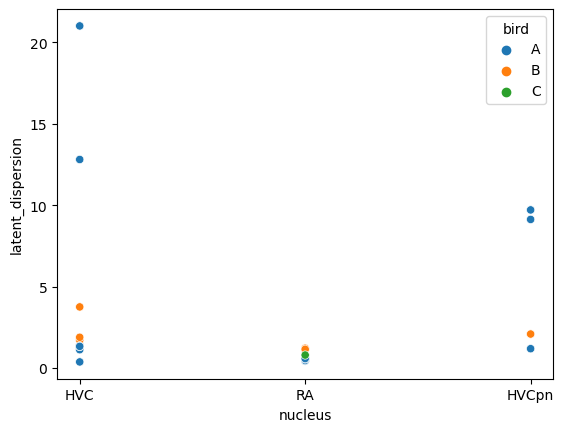

In [ ]:
sns.scatterplot(data=lfads_df, x="nucleus", y='latent_dispersion', hue="bird")

Ploting run:  0
Ploting run:  1
Ploting run:  2
Ploting run:  3
Ploting run:  4
Ploting run:  5
Ploting run:  6
Ploting run:  7
Ploting run:  8
Ploting run:  9
Ploting run:  10
Ploting run:  11
Ploting run:  12
Ploting run:  13
Ploting run:  14
Ploting run:  15
Ploting run:  16
Ploting run:  17
Ploting run:  18
Ploting run:  19
Ploting run:  20


/tmp/ipykernel_1447/2963108373.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=True, figsize=(10, 4))


Ploting run:  21
Ploting run:  22
Ploting run:  23


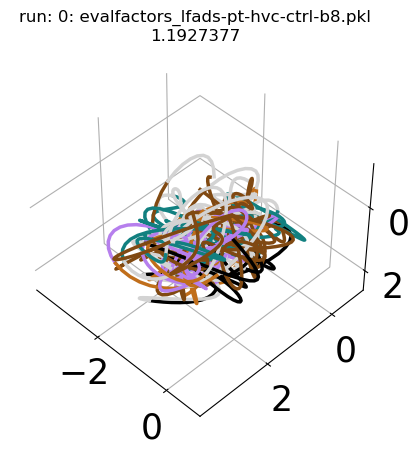

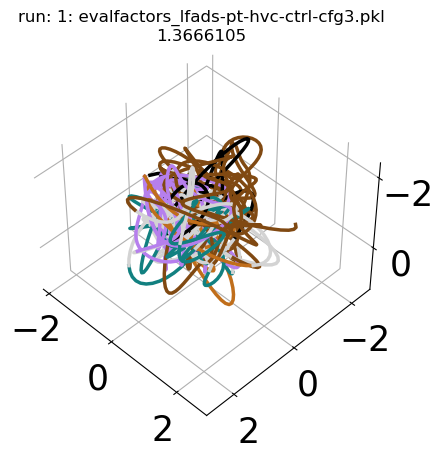

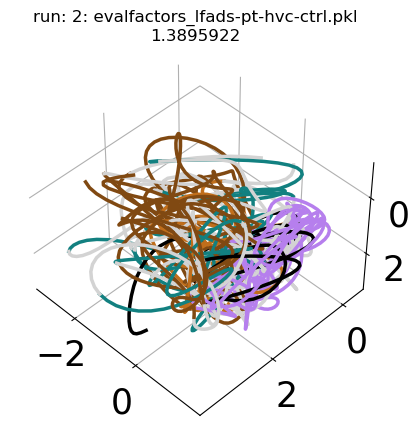

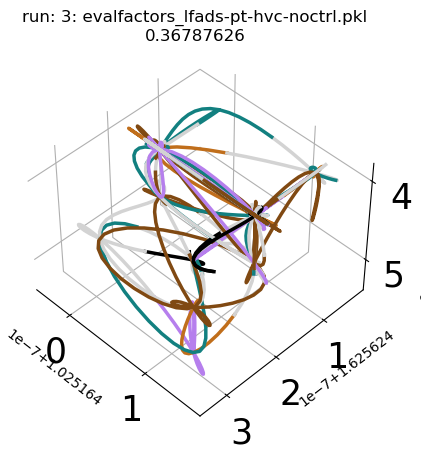

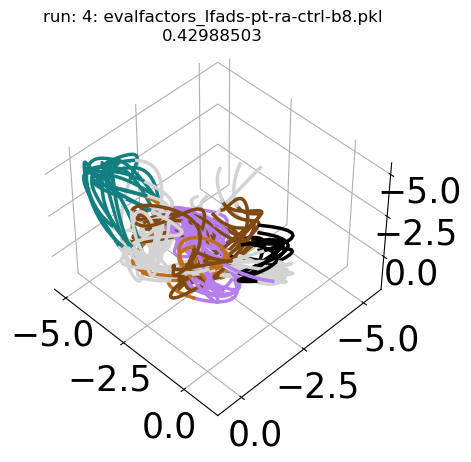

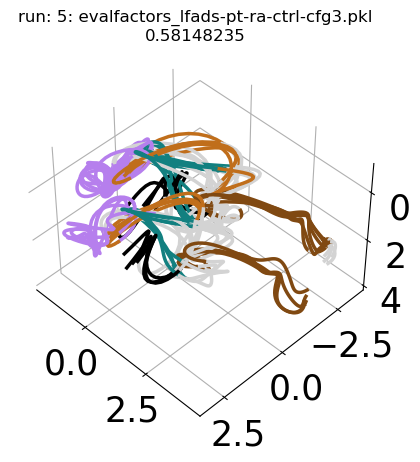

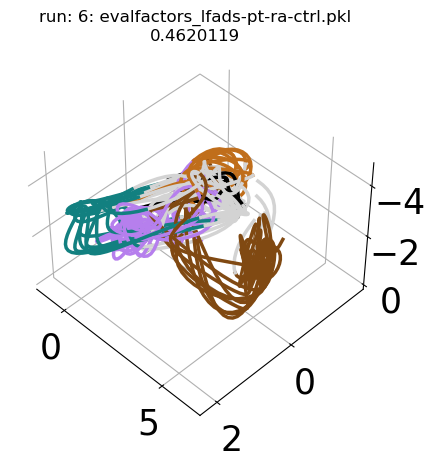

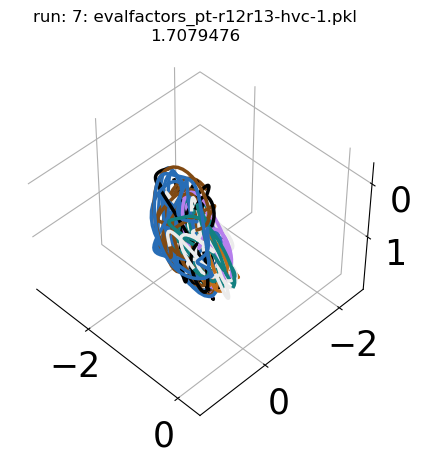

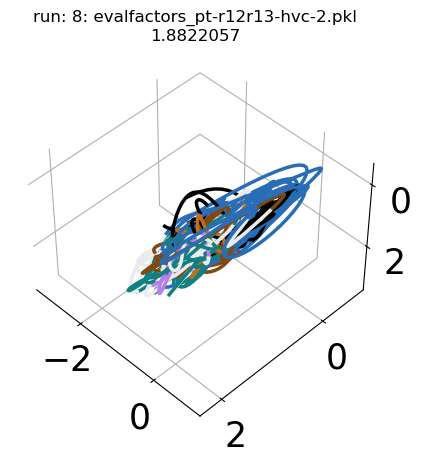

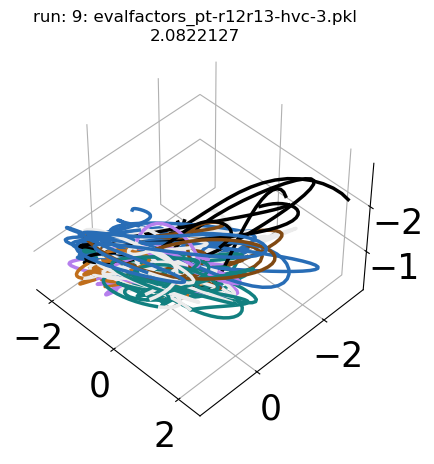

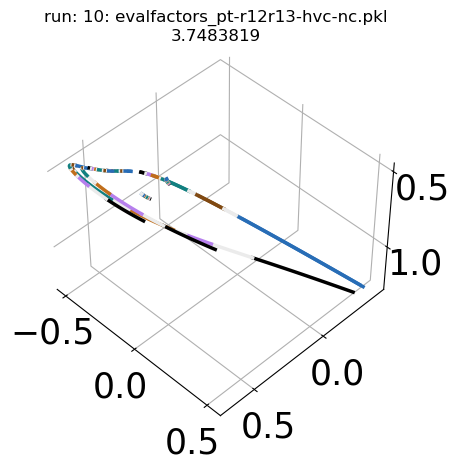

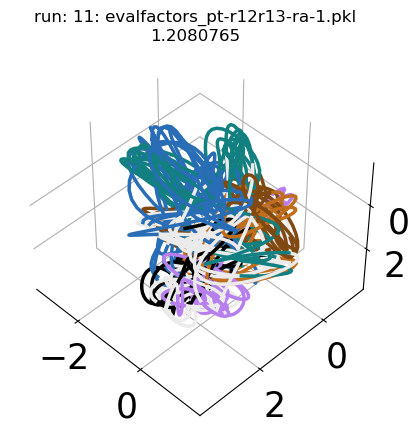

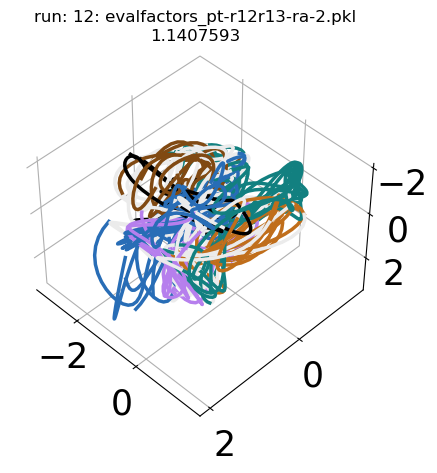

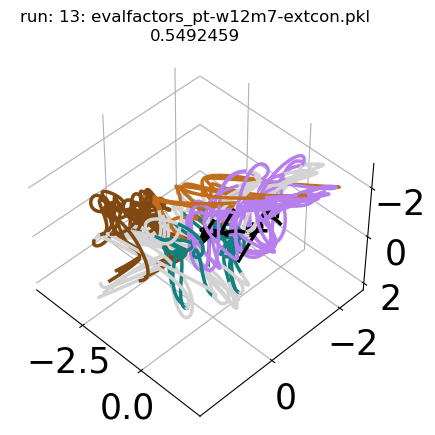

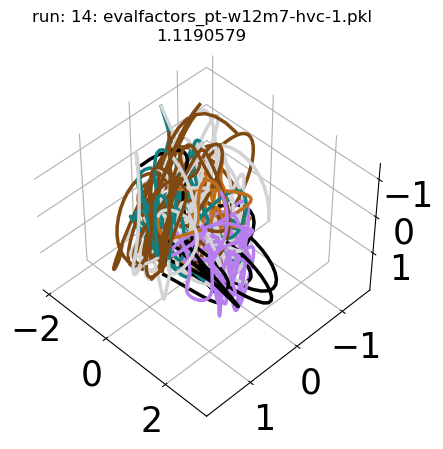

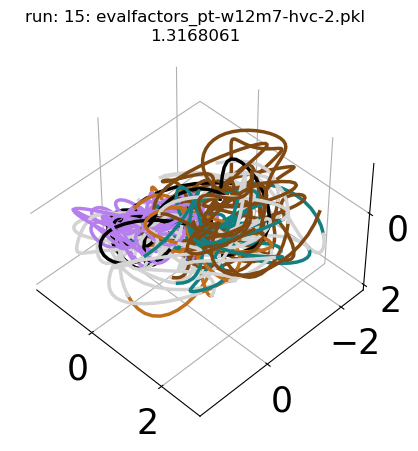

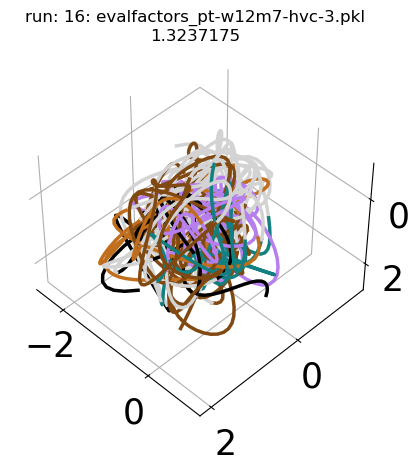

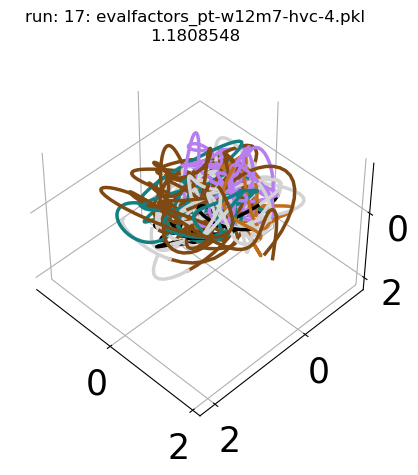

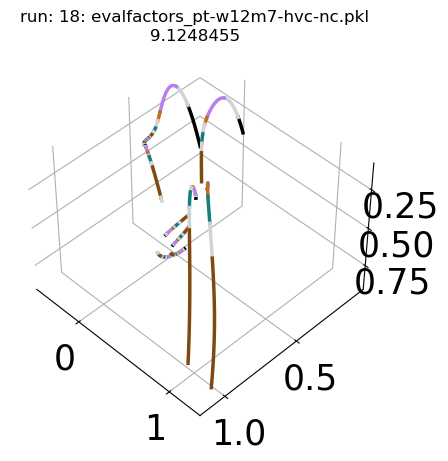

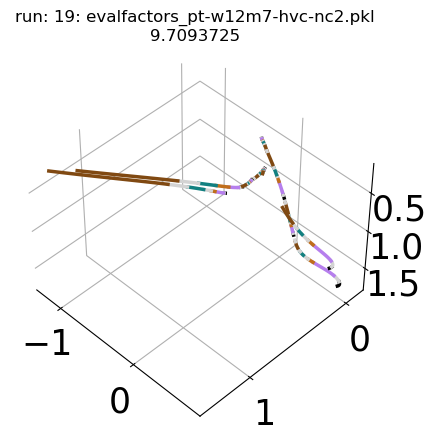

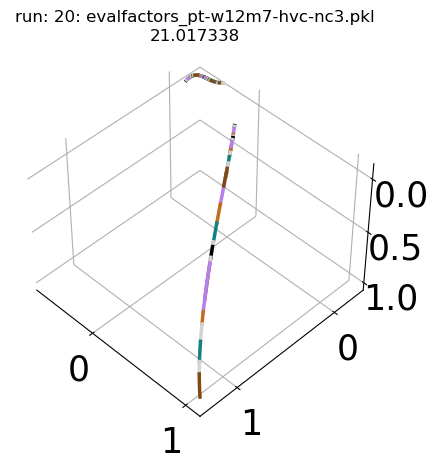

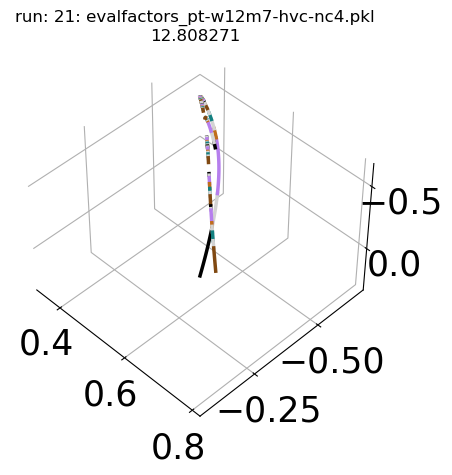

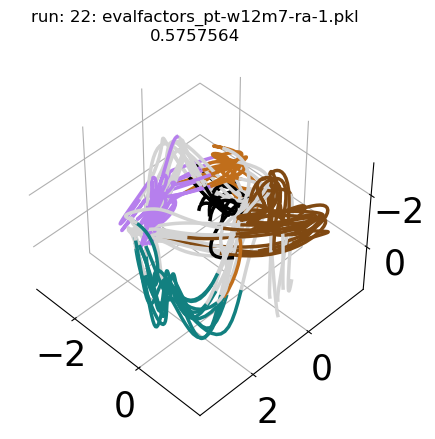

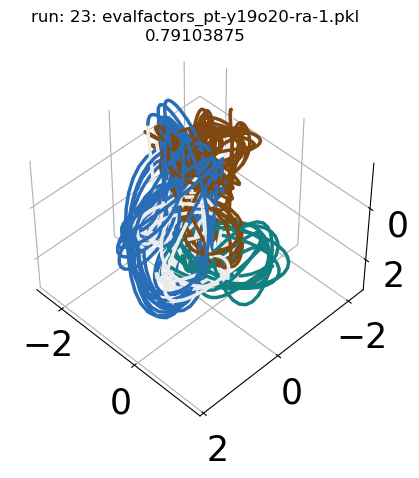

In [ ]:
for run in range(len(lfads_df)):
    
    print('Ploting run: ', run)
    
    # Extract motif period
    start_s = 2
    mot_len_s = lfads_df['mot_len'][run]
    bin_w = lfads_df['bin_w'][run]
    int_m = interpolation_multiplier
    fs_ap=1000

    start_bin, end_bin, start_bin_interp, end_bin_interp = compute_start_end_samples(start_s=start_s, mot_len_s=mot_len_s, bin_w=bin_w, int_m=int_m, fs_ap=1000)
    
    # Load trajectories
    path_file = lfads_df['lfads_dir'][0] + lfads_df['lfads_run'][run]
    with open(path_file, "rb") as input_file:
        lfads_trajectories = pickle.load(input_file)
        lfads_trajectories = np.transpose(lfads_trajectories, axes=[0,2,1])

    # Load trajectory labels
    labels_file = lfads_df['trajectory_labels'][run]
    with open(labels_file, "rb") as input_file:
        traj_labels = pickle.load(input_file)
        
    # Smooth trajectories
    smooth_lfads = []
    for mot in range(len(lfads_trajectories)): 
        smooth_lfads.append(np.apply_along_axis(lu.signal_smoother, 1, lfads_trajectories[mot], interp_multiplier=interpolation_multiplier, interp_order=interpolation_order))
    smooth_lfads = np.array(smooth_lfads)
    # Smooth labels accordingly
    smooth_traj_labels = np.apply_along_axis(lu.list_expander, 1, traj_labels, expand_multiplier=interpolation_multiplier)
    # Find label edges
    lbl_edges = lu.find_label_edges_2D(smooth_traj_labels)
    
    plot_trajectories(smooth_lfads, smooth_traj_labels)
    plt.title('run: ' + str(run) + ': ' + lfads_df['lfads_run'][run] + '\n' + str(lfads_df['latent_dispersion'][run]))

In [ ]:
run = 3

In [ ]:
# Extract motif period
start_s = 2
mot_len_s = lfads_df['mot_len'][run]
bin_w = lfads_df['bin_w'][run]
int_m = interpolation_multiplier
fs_ap=1000

start_bin, end_bin, start_bin_interp, end_bin_interp = compute_start_end_samples(start_s=start_s, mot_len_s=mot_len_s, bin_w=bin_w, int_m=int_m, fs_ap=1000)

# Load trajectories
path_file = lfads_df['lfads_dir'][0] + lfads_df['lfads_run'][run]
with open(path_file, "rb") as input_file:
    lfads_trajectories = pickle.load(input_file)
    lfads_trajectories = np.transpose(lfads_trajectories, axes=[0,2,1])

# Load trajectory labels
labels_file = lfads_df['trajectory_labels'][run]
with open(labels_file, "rb") as input_file:
    traj_labels = pickle.load(input_file)

# Calculate trajectories dispersion
latent_dispersion = calculate_latent_dispersion(lfads_trajectories[:, :, start_bin:end_bin])
print('run: ', run, np.mean(latent_dispersion), np.std(latent_dispersion))

mean_dispersion.append(np.mean(latent_dispersion))
std_dispersion.append(np.std(latent_dispersion))  

run:  3 0.36787626 0.020927964


In [ ]:
# RA Ssmooth trajectories
smooth_lfads = []
for mot in range(len(lfads_trajectories)): 
    smooth_lfads.append(np.apply_along_axis(lu.signal_smoother, 1, lfads_trajectories[mot], interp_multiplier=interpolation_multiplier, interp_order=interpolation_order))
smooth_lfads = np.array(smooth_lfads)

# Smooth labels accordingly
smooth_traj_labels = np.apply_along_axis(lu.list_expander, 1, traj_labels, expand_multiplier=interpolation_multiplier)

# Find label edges
lbl_edges = lu.find_label_edges_2D(smooth_traj_labels)


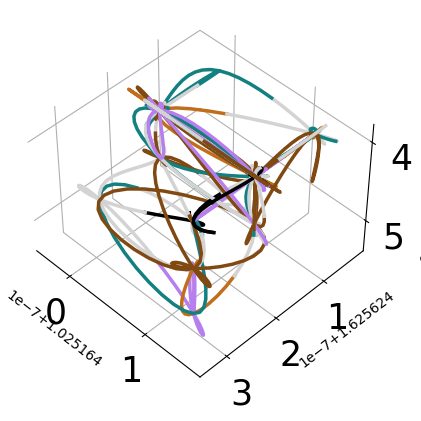

In [ ]:
ax = plot_trajectories(smooth_lfads, smooth_traj_labels)

### Aashish's LFADS data

In [ ]:
import h5py
filename = "/net2/sandbox/NeuralLatent/LFADS_Input/" + "mc_maze_20_train_lfads.h5"

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]
    
    data = list(f[a_group_key])
    
print(data[0].shape)
print(np.min(data[0]), np.max(data[0]))

Keys: <KeysViewHDF5 ['train_data', 'train_inds', 'valid_data', 'valid_inds']>
(45, 182)
0.0 3.0
